<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and Function Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)

In [6]:
df = pd.DataFrame(data=online_shoppers_purchasing_intention_dataset.data.features)

In [7]:
df["target"] = online_shoppers_purchasing_intention_dataset.data.targets

In [ ]:
df

In [8]:
#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

In [46]:
#Lets make an anova test to see if this much category is needed
def barplots(dataframe, label, target):
    from scipy import stats
    """
    Takes dataframe, feature and target as parameter
    Applies t-tests for categorical features
    Returns a barpot with t-stat and p values"""
    ttests = []
    string = "Categories  t stat  p value \n "
    if pd.api.types.is_numeric_dtype(dataframe[label]) == False and len(dataframe[label].unique()) <= 25 and len(dataframe[label].unique())>=2:
        e_types = dataframe[label].unique()
        for i, e in enumerate(e_types):
            for i2, e2 in enumerate(e_types):
                if i2 >= i :
                    g1 = dataframe[dataframe[label] == e][target]
                    g2 = dataframe[dataframe[label] == e2][target]
                    t, p = stats.ttest_ind(g1,g2)
                    ttests.append([f"{e} - {e2}", t, p])
                    string += (f"{e} - {e2}: {t:.4f}, {p:.5f} " + " \n ")
                    if p < 0.05:
                        string += "Significant" + "\n"
                    else:
                        string += "Not Significant" + "\n"
        plt.figure()
        plt.figsize=(10,6)
        plt.text(5, 0.1, string, fontsize = 8)
        viz = sns.barplot(data = dataframe, x = label , y = target,)
        viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)
        viz.set(title = f"{target} by {label}")
        plt.show()

In [10]:
#To start visualizing data, lets first see the best features in terms of explainin the variance of target
def correlation(dataframe, target):
    from scipy import stats
    """
    Takes dataframe and target feature as parameter
    Returns the correlation between numeric columns and target"""

    output_dataframe = pd.DataFrame(columns = ["Columns","P-Value","Correlation Coefficient(r)","Absolute r"])
    for col in dataframe.drop(target,axis = 1):
        try:
            if pd.api.types.is_numeric_dtype(dataframe[col]):
                r, p = stats.pearsonr(dataframe[col],dataframe[target])
                output_dataframe.loc[col] = [f"{target}-{col}",round(p,4),r,abs(r)]
            else:
                pass
        except:
            pass

    return output_dataframe.sort_values(by = ["Absolute r"],ascending = False)

In [11]:
def hist_and_boxplot(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns histogram and boxplot"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.histplot(data = dataframe, x = label)
    plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, x = label)
    plt.show();

def categorical_pie(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns pie chart along with value counts"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    dataframe[label].value_counts().plot.pie(autopct = "%1.1f%%")
    plt.subplot(1,2,2)
    sns.countplot(data = dataframe, x = label)

In [12]:
def scatter(dataframe, target, feature):
    from statsmodels.formula.api import ols
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy import stats
    """
    Takes dataframe, target and feature as parameter
    Use it with a numeric column
    Fits an OLS model with the given feature
    Applies breuschpagan test
    Returns the scatterplot, regression and test results.
    """

    sns.set_style(style="white")

    model = ols(formula= f"{target}~{feature}", data = dataframe).fit()

    lm, p1, f, p2 = het_breuschpagan(model.resid,model.model.exog)
    m, b, r, p, err = stats.linregress(dataframe[feature], dataframe[target])

    string = "y = " + str(round(m,2)) + "x " + str(round(b,2)) + "\n"
    string += "r_2 = " + str(round(r**2, 4))  + "\n"
    string += str(round(r**2, 4)*100) + "% of variance is explained" + "\n"
    string += "p = " + str(round(p, 5)) + "\n"
    if p < 0.05:
        string += "Significant" + "\n"
    else:
        string += "Not Significant" + "\n"
    string += str(dataframe[feature].name) + " skew = " + str(round(dataframe[feature].skew(), 2)) + "\n"
    if dataframe[feature].skew() < 0:
        string += str(dataframe[feature].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[feature].name) + " is positively skewed" + "\n"
    string += str(dataframe[target].name) + " skew = " + str(round(dataframe[target].skew(), 2)) + "\n"
    if dataframe[target].skew() < 0:
        string += str(dataframe[target].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[target].name) + " is positively skewed" + "\n"
    string += str(dataframe[feature].name) + " Breushpagan Test = " + "LM stat: " + str(round(lm,4)) + " p value: " + str(round(p1,4)) + " F stat: " + str(round(f,4)) + " p value: " + str(round(p2,4)) + "\n"
    if p1 < 0.05:
        string += "Variance of residuals are not distributed equally" + "\n"
    else:
        string += "Variance of residuals are distributed equally" + "\n"
    ax = sns.jointplot(x = feature, y = target, kind = "reg", data = dataframe)
    ax.fig.text( 1, 0.1, string, fontsize = 12, transform = plt.gcf().transFigure)


# EDA

## Summary

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

From the initial stage we see that we have some object and boolean type variables in addition to numerous variables.
Here I do not observe any null value but the dataset may include null values in the name of 0s or strings as null.

In [19]:
#Lets change the boolean values into 1-0s for ease of use
df["Weekend"] = df["Weekend"].astype(int)
df["Revenue"] = df["target"].astype(int)
df.drop("target", axis = 1, inplace = True)

In [21]:
unistats(df)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Administrative,12330,0,27,int64,0.0,2.315166,0.0,0.0,1.0,4.0,27.0,3.321784,1.960357,4.701146
Informational,12330,0,17,int64,0.0,0.503569,0.0,0.0,0.0,0.0,24.0,1.270156,4.036464,26.932266
ProductRelated,12330,0,311,int64,1.0,31.731468,0.0,7.0,18.0,38.0,705.0,44.475503,4.341516,31.211707
OperatingSystems,12330,0,8,int64,2,2.124006,1,2.0,2.0,3.0,8,0.911325,2.066285,10.456843
Browser,12330,0,13,int64,2,2.357097,1,2.0,2.0,2.0,13,1.717277,3.24235,12.746733
Region,12330,0,9,int64,1,3.147364,1,1.0,3.0,4.0,9,2.401591,0.983549,-0.14868
TrafficType,12330,0,20,int64,2,4.069586,1,2.0,2.0,4.0,20,4.025169,1.962987,3.479711
Weekend,12330,0,2,int64,0,0.232603,0,0.0,0.0,0.0,1,0.422509,1.265962,-0.397404
Revenue,12330,0,2,int64,0,0.154745,0,0.0,0.0,0.0,1,0.361676,1.909509,1.646493
Administrative_Duration,12330,0,3335,float64,0.0,80.818611,0.0,0.0,7.5,93.25625,3398.75,176.779107,5.615719,50.556739


* Administrative: This is the number of pages of this type (administrative) that the user visited. Integer continous variable. Slightly right skewed.

* Informational: This is the number of pages of this type (informational) that the user visited. Integer continous variable. Right skewed

* ProductRelated: This is the number of pages of this type (product related) that the user visited. Integer continous variable. Right skewed

* OperatingSystems: An integer value representing the operating system that the user was on when viewing the page. Categorical feature encoded labelly. We may one hot encode.

* Browser: An integer value representing the browser that the user was using to view the page. Categorical feature encoded labelly. We may one hot encode.

* Region: An integer value representing which region the user is located in.
Categorical feature encoded labelly. We may one hot encode.

* TrafficType: An integer value representing what type of traffic the user is categorized into. Categorical feature encoded labelly. We may one hot encode.

* Weekend: A boolean representing whether the session is on a weekend.

* Revenue: A boolean representing whether or not the user completed the purchase. Our target variable.

* Administrative Duration: This is the amount of time spent in this category of pages. Continous float variable. Highly right skewed.

* Informational Duration: This is the amount of time spent in this category of pages. Continous float variable. Highlt right skewed.

* Product Related Duration: This is the amount of time spent in this category of pages. Continous float variable. Highly right skewed.

* Bounce Rates: The percentage of visitors who enter the website through that page and exit without triggering any additional tasks. Continous float variable. right skewed.

* Exit Rates: The percentage of pageviews on the website that end at that specific page. Continous float variable. Right skewed.

* Page Values: The average value of the page averaged over the value of the target page and/or the completion of an eCommerce transaction. Continous float variable. Highly right skewed.

* Speacil Day: This value represents the closeness of the browsing date to special days or holidays (eg Mother's Day or Valentine's day) in which the transaction is more likely to be finalized. Categorical variable encoded labelly. We may one hot encode.

* Month: Contains the month the pageview occurred, in string form. Date related. We can both label or one hot encode.

* Visitor Type: A string representing whether a visitor is New Visitor, Returning Visitor, or Other. Categorical variable.

## Correlation

<Axes: >

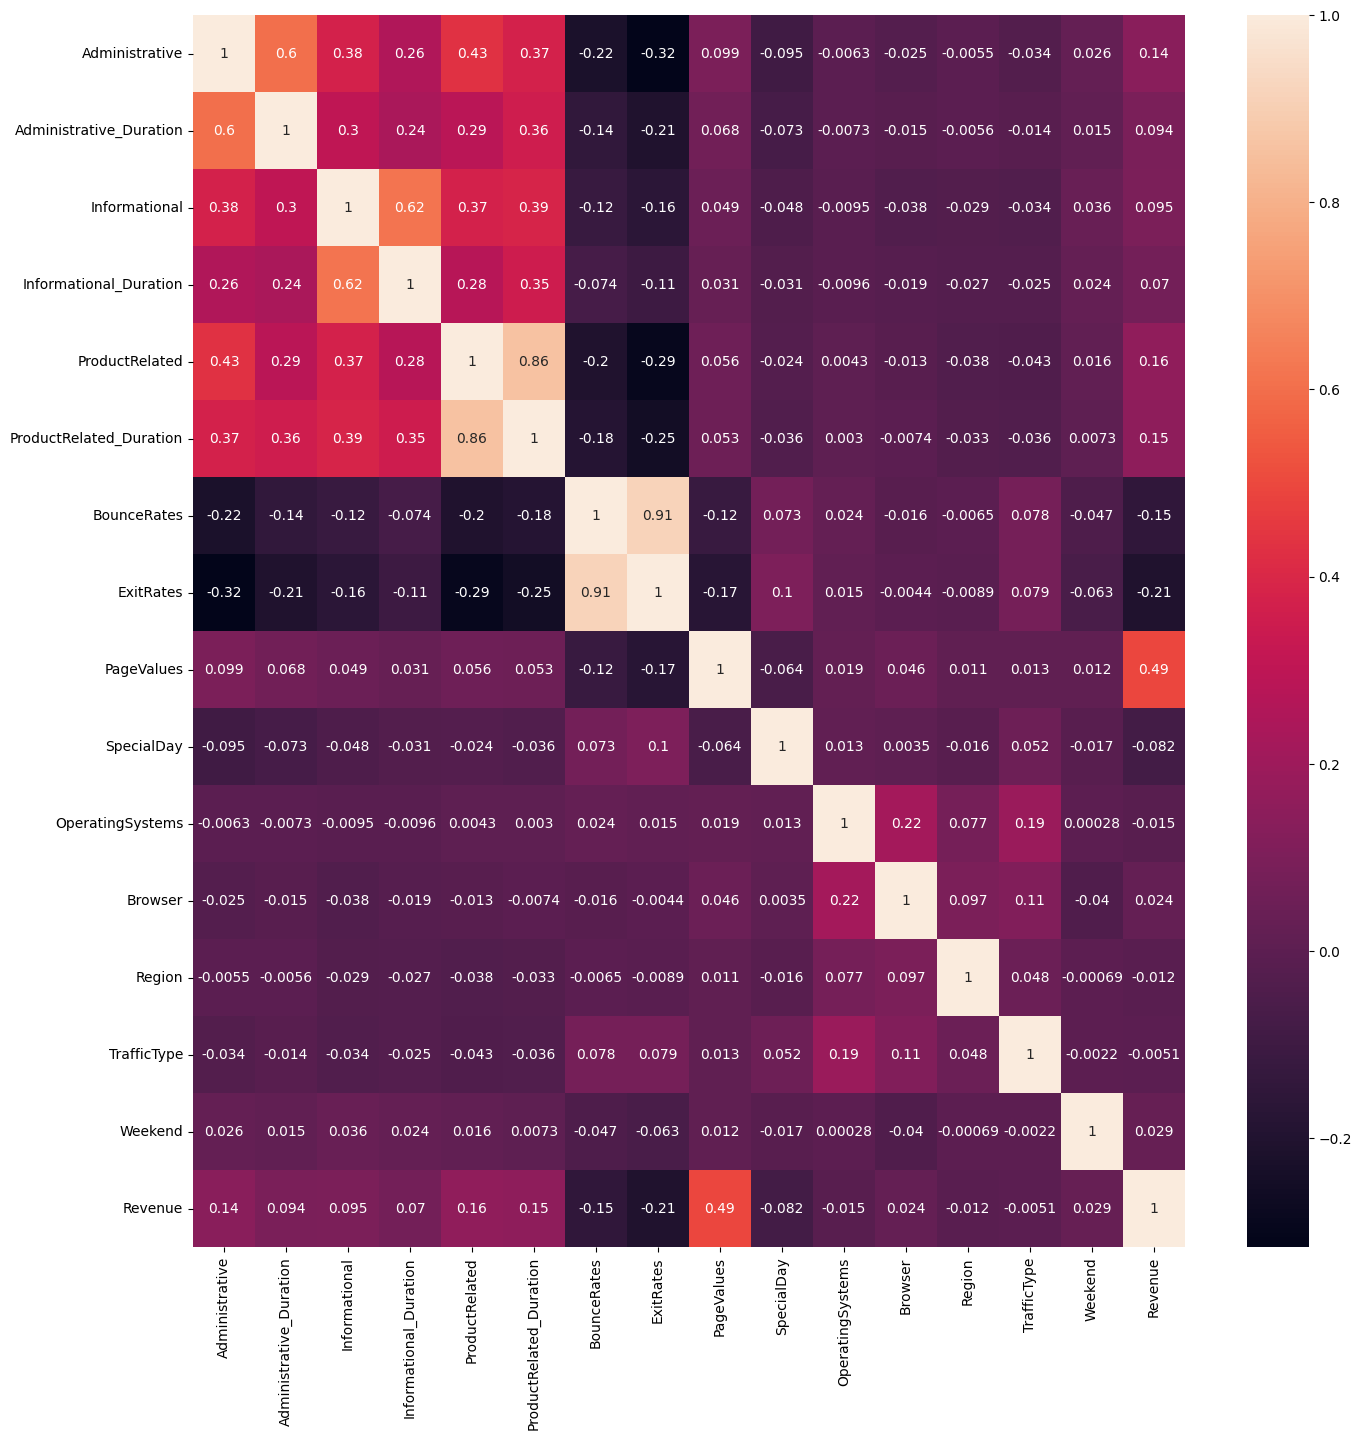

In [25]:
#Lets look at the correlation matrix
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(numeric_only=True), annot = True)

* We observe high correlation between the durations of respective category. For example administrative with administrative duration, product and informational as well. This collinearity may cause problems hence we may choose one of them to use as a feature.
* Page values seems to be the best feature since it correlates to our target variable 0.49.
* Traffic type is slightly correlated with operating system.
* Above |0.1| we have 6 numeric features.
* As a result: we have to solve multicollinearity and increase the number of useful features.

## Distribution

### Administrative

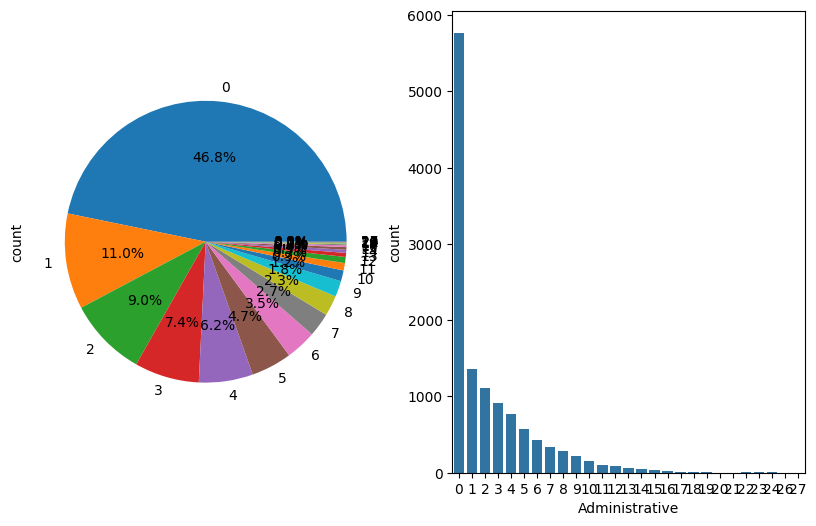

In [28]:
categorical_pie(df, "Administrative")

* We have 0 in the majority.
* The category of admins are not much after 0.

<Axes: xlabel='Administrative', ylabel='Revenue'>

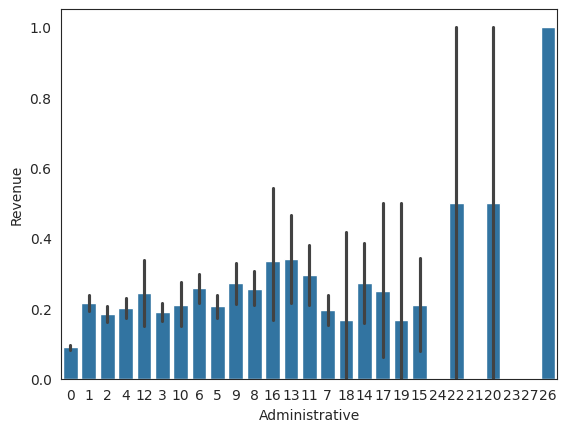

In [90]:
sns.barplot(data = df, x = "Administrative", y = "Revenue")

Since there are many categories and not that much data, variance for each category in terms of revenue is very high. Hence we cannot conclude important outcomes.

### Administrative Duration

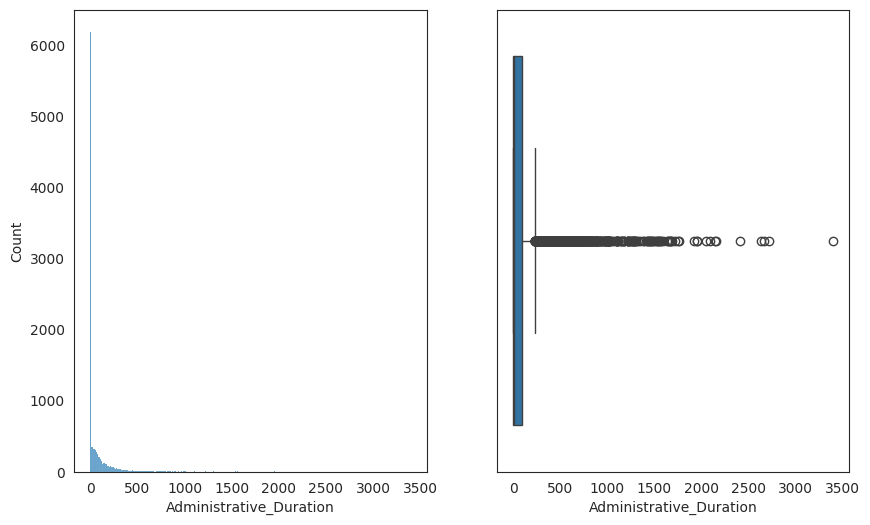

In [50]:
hist_and_boxplot(df, "Administrative_Duration")

* Here we observe highly right skew as mentioned before. This is because of the number of 0 values.

As we can see, we have many 0 values. Lets look at the distribution without 0s

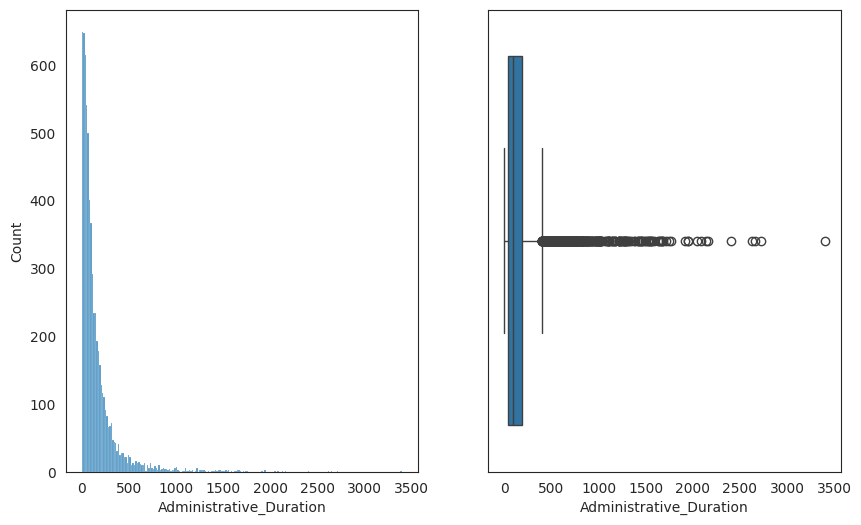

In [53]:
hist_and_boxplot(df[df["Administrative_Duration"] != 0], "Administrative_Duration")

As we can see, even without the 0s the distribution tends to skew and produce many outliers. In the feature engineering part, we may create a range feature.

### Informational

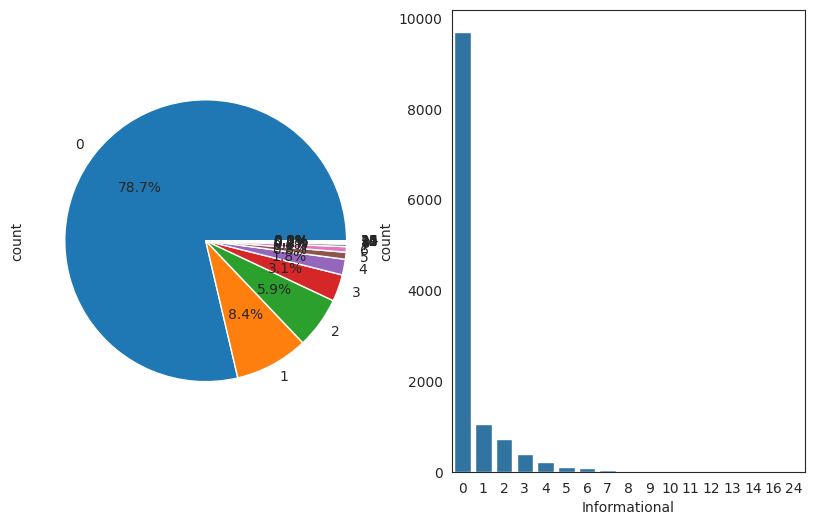

In [54]:
categorical_pie(df, "Informational")

* Again we have 0 values at the majority.
* We can create a feature for both admin and info as a boolean: is_zero

<Axes: xlabel='Informational', ylabel='Revenue'>

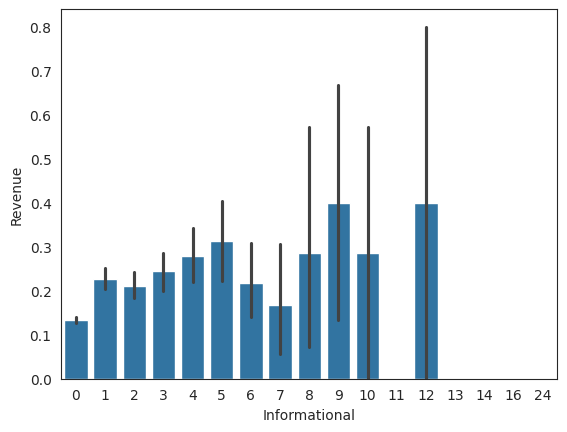

In [92]:
sns.barplot(data = df, x = "Informational", y = "Revenue")

Again, the high number of categories and small number of data points increases the variance.

### Informational Duration

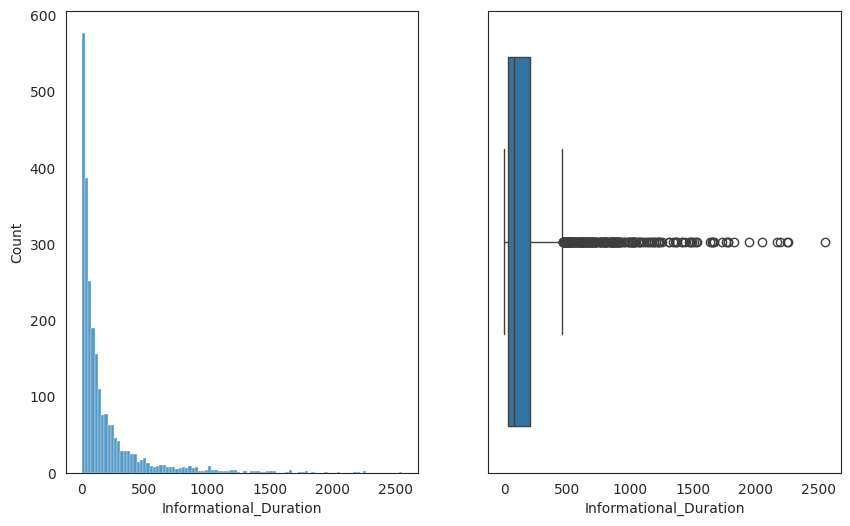

In [56]:
hist_and_boxplot(df[df["Informational_Duration"]!=0], "Informational_Duration")

Again we observe a right skewed distribution similar to an exponential. Which is good since we can fit a distribution for later unseen data points

### Product

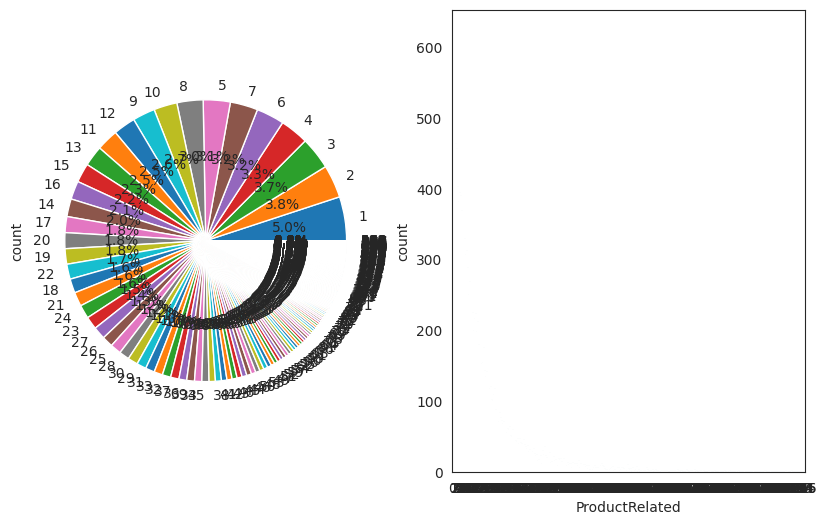

In [57]:
categorical_pie(df, "ProductRelated")

Here we have too many categories, with this much of data we cannot efficiently use this much category in the model

### Product Duration

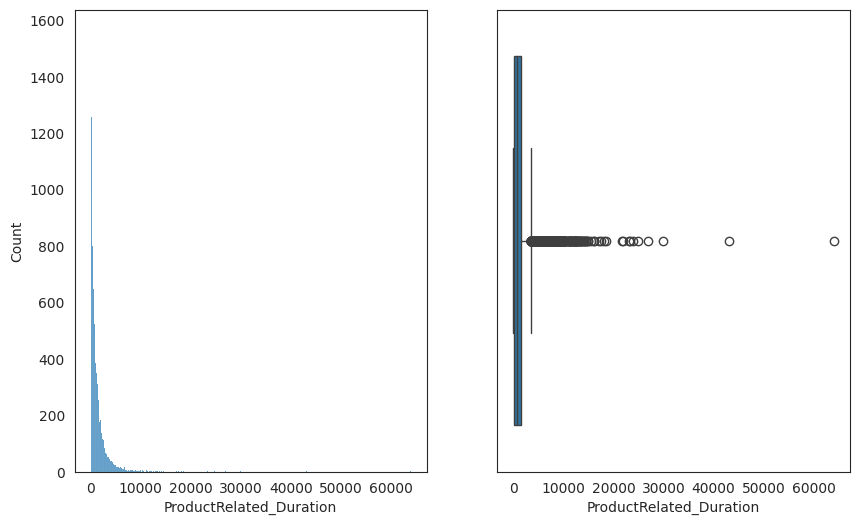

In [58]:
hist_and_boxplot(df[df["ProductRelated_Duration"]!=0], "ProductRelated_Duration")

Similar to other duration distributions. We can fit to an exponential dist here as well.

### Bounce Rates

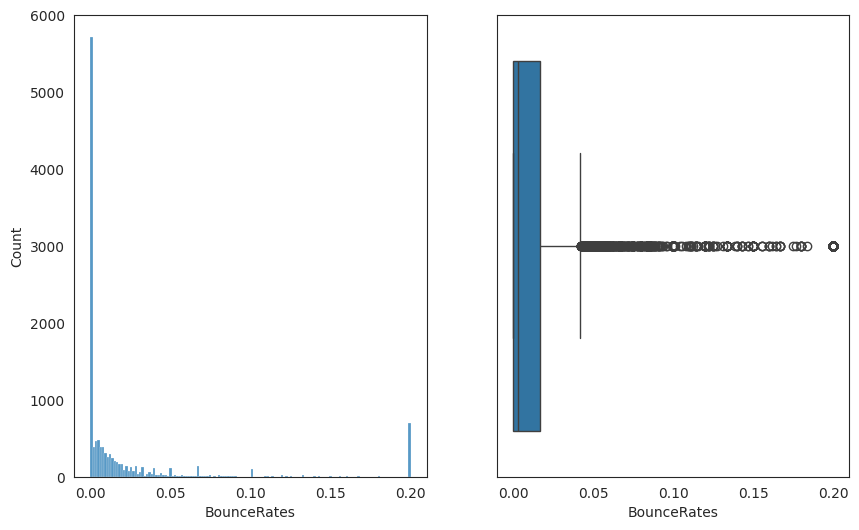

In [60]:
hist_and_boxplot(df, "BounceRates")

Her we again observe too many 0s

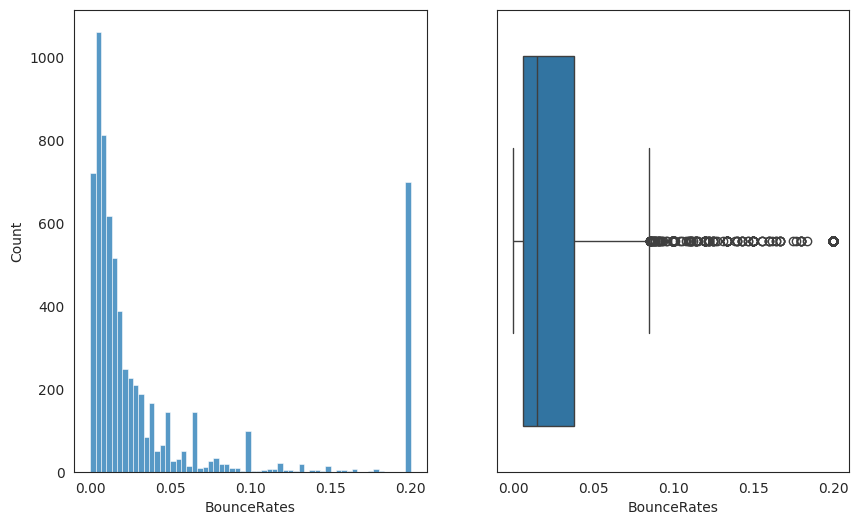

In [61]:
hist_and_boxplot(df[df["BounceRates"]!=0], "BounceRates")

Without 0s we have a much logical histogram and a boxplot.
* We have again too much outliers especially those on 0.2
* Without the peek at 0.2, we can also fit into exponential distribution again.
* At most 20% of the customers churn from the site without any proceedings.

### Exit Rates

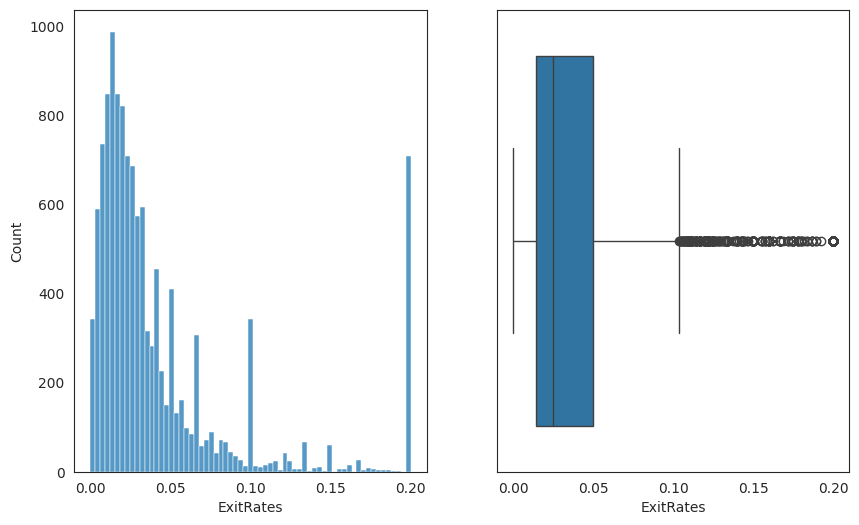

In [62]:
hist_and_boxplot(df, "ExitRates")

Finally some good looking shapes !
* Here we again observe a similar distribution to bounce rates.
* We already mentioned the correlation between exit and bounce rates are up to 91%.
* Hence it is better for us to use only one of them.

### Page Values

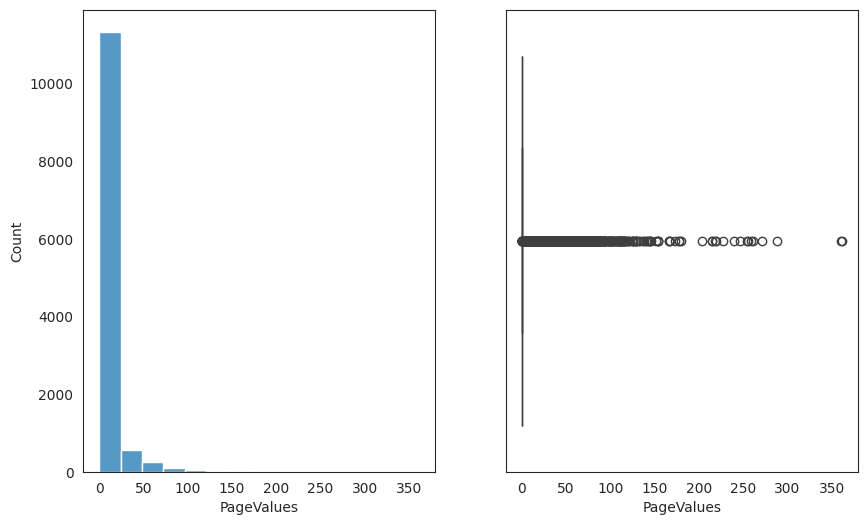

In [64]:
hist_and_boxplot(df, "PageValues")

* Succeeding in here means a revenue already hence large number of 0s are not surprising.
* Lets look at the relation between outliers and revenue.

In [70]:
print("Number of churned when page value is 0:", df[df["PageValues"]==0]["Revenue"].value_counts()[0])
print("Number of churned when page value is not 0:", df[df["PageValues"]!=0]["Revenue"].value_counts()[0])

Number of churned when page value is 0: 9230
Number of churned when page value is not 0: 1192


Hence a success in page value directly affects the success in revenue

### Special Day

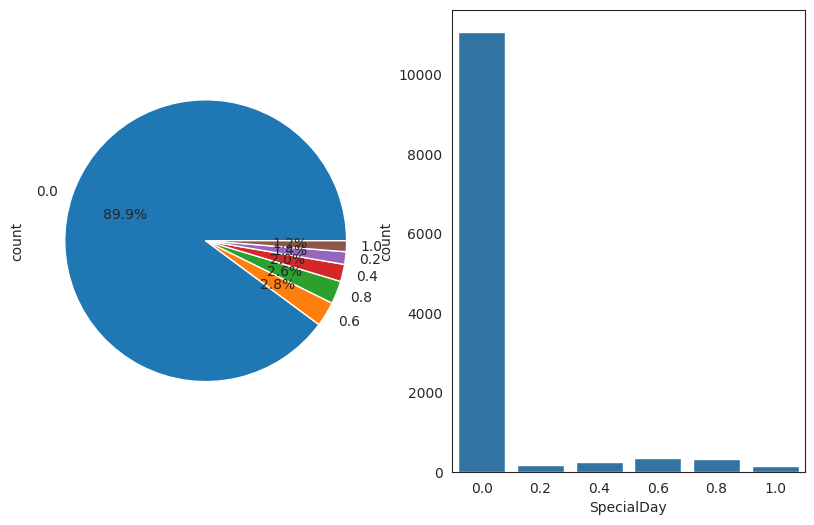

In [71]:
categorical_pie(df, "SpecialDay")

In [73]:
print("Number of churned customers in no special day upcoming:", df[df["SpecialDay"]==0]["Revenue"].value_counts()[0])
print("Number of churned customers in special day upcoming:", df[df["SpecialDay"]!=1]["Revenue"].value_counts()[0])

Number of churned customers in no special day upcoming: 9248
Number of churned customers in special day upcoming: 10278


In contrary to what we would expect, special days upcoming are not that related

In [74]:
print("Ratio of churn in special day upcoming:", df[df["SpecialDay"]!=0]["Revenue"].value_counts()[0]/df[df["SpecialDay"]!=0]["Revenue"].value_counts()[1])
print("Ratio of churn in no special day upcoming:", df[df["SpecialDay"]==0]["Revenue"].value_counts()[0]/df[df["SpecialDay"]==0]["Revenue"].value_counts()[1])

Ratio of churn in special day upcoming: 15.246753246753247
Ratio of churn in no special day upcoming: 5.050791916985254


We also does not see a better of in the churn ratio.

<Axes: xlabel='SpecialDay', ylabel='Revenue'>

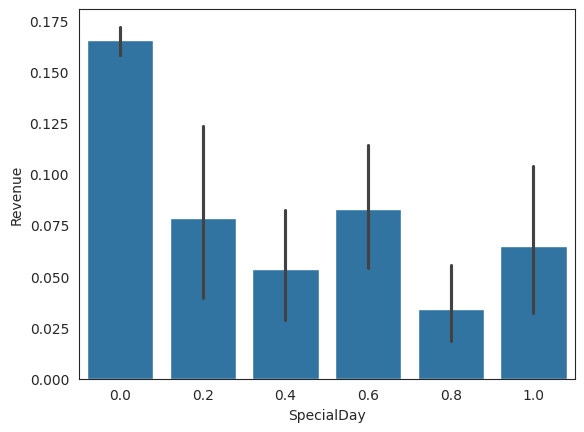

In [93]:
sns.barplot(data = df, x = "SpecialDay", y = "Revenue")

As we concluded above, there is no strong relation between special day and revenue

### Month

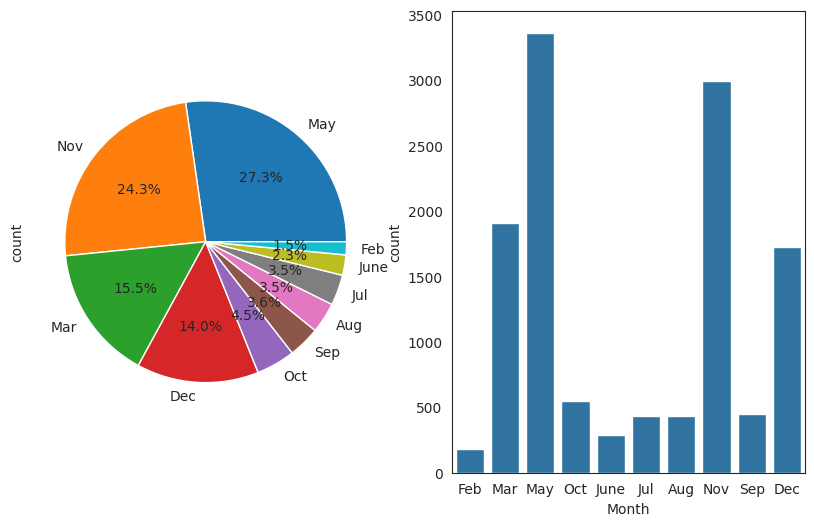

In [75]:
categorical_pie(df, "Month")

* March, May, November and December is the most seen months

<Axes: xlabel='Month', ylabel='Revenue'>

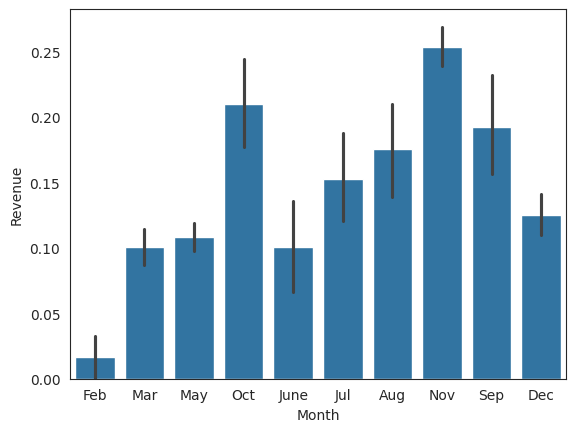

In [76]:
sns.barplot(data = df, x = "Month", y = "Revenue")

* In terms of revenue we see that October and November leads the revenue race.
* Although we see more customers in december and less in july, the revenue graph tell july is better than december.
* Hence number of customers entering the page in a month is not directly related to the revenue

### Operating System

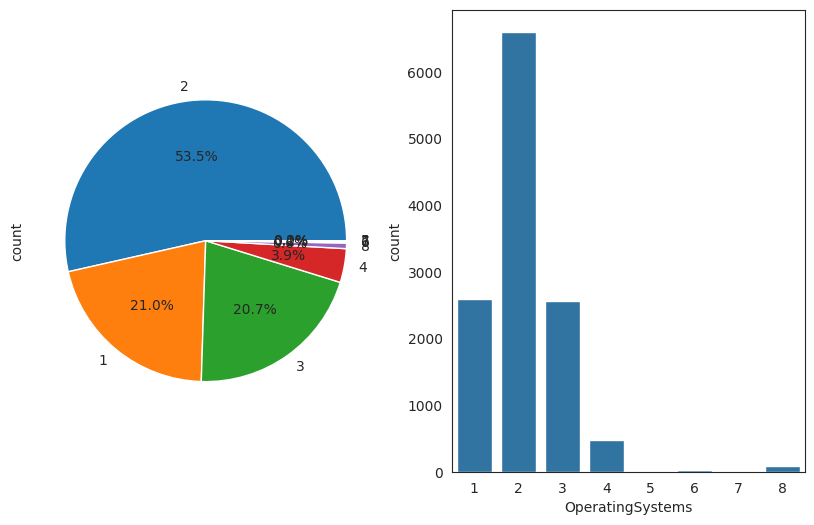

In [77]:
categorical_pie(df, "OperatingSystems")

* We see the majority uses type 2 operating system.
* User of 4-5-6-7-8 are very less. Hence we can group them together in the feature engineering part.

<Axes: xlabel='OperatingSystems', ylabel='Revenue'>

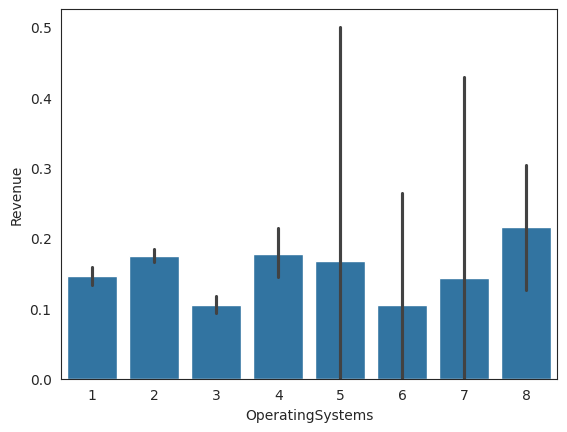

In [78]:
sns.barplot(data = df, x = "OperatingSystems", y = "Revenue")

Not significant change among operationg systems on the revenue.

### Browser

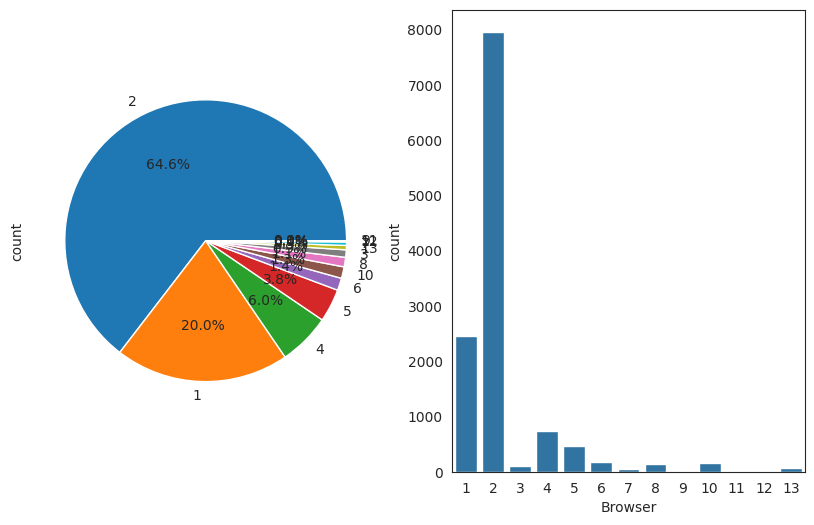

In [79]:
categorical_pie(df, "Browser")

* 2 is probably chrome. People mostly use 1 and 2. Rest can be grouped.

<Axes: xlabel='Browser', ylabel='Revenue'>

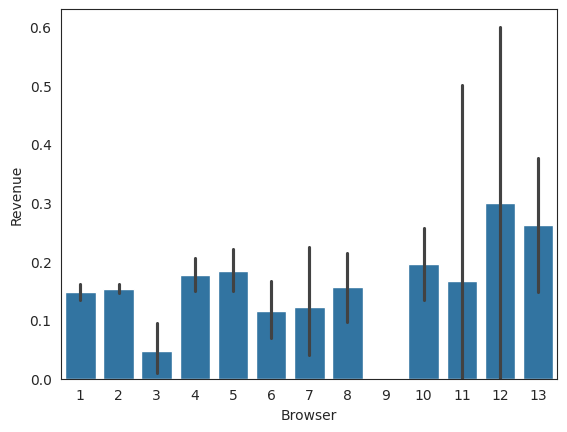

In [80]:
sns.barplot(data = df, x = "Browser", y = "Revenue")

Again browser seems irrelevant to revenue stream we got.

### Region

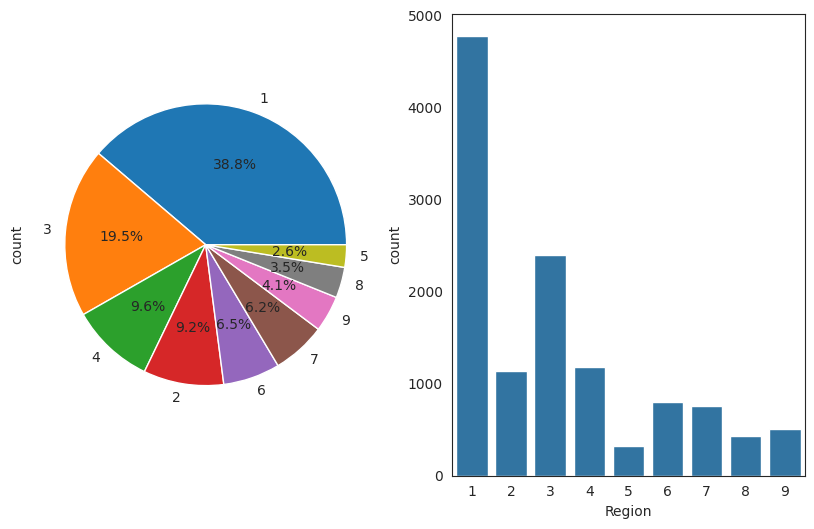

In [81]:
categorical_pie(df, "Region")

* We mostly endavour customers from region 1 and 3.

<Axes: xlabel='Region', ylabel='Revenue'>

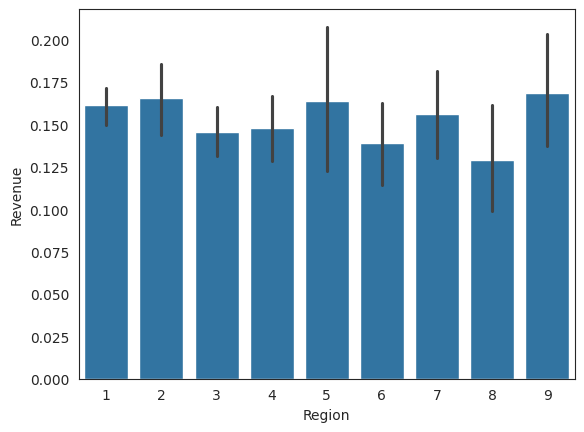

In [82]:
sns.barplot(data = df, x = "Region", y = "Revenue")

* Region is also not differs among regions.

### Traffic Type

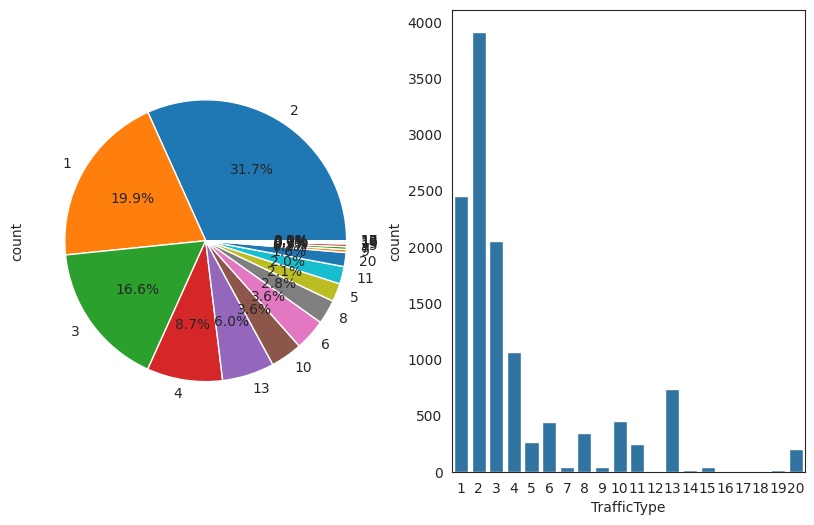

In [83]:
categorical_pie(df, "TrafficType")

We see high amount of traffic in type 1,2,3

<Axes: xlabel='TrafficType', ylabel='Revenue'>

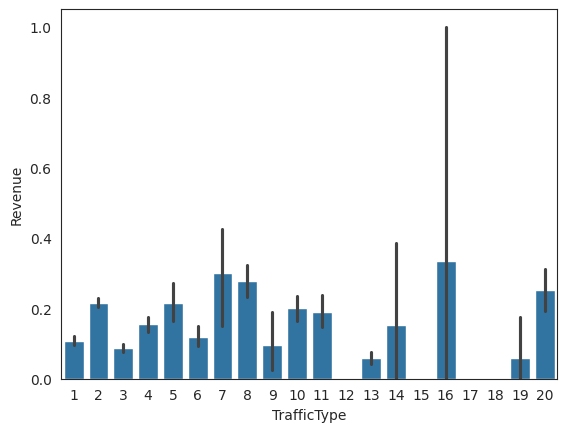

In [84]:
sns.barplot(data = df, x = "TrafficType", y = "Revenue")

Some traffic types do not show up such as 12,15,17,18 hence revenues are zero. But not much different from the barplot above without revenue.

### Visitor Type

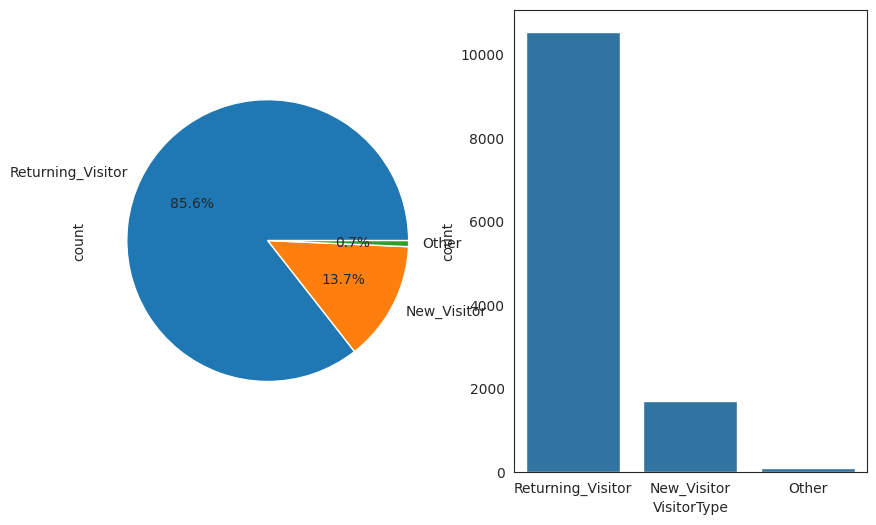

In [85]:
categorical_pie(df, "VisitorType")

* We have mostly returning visitors

<Axes: xlabel='VisitorType', ylabel='Revenue'>

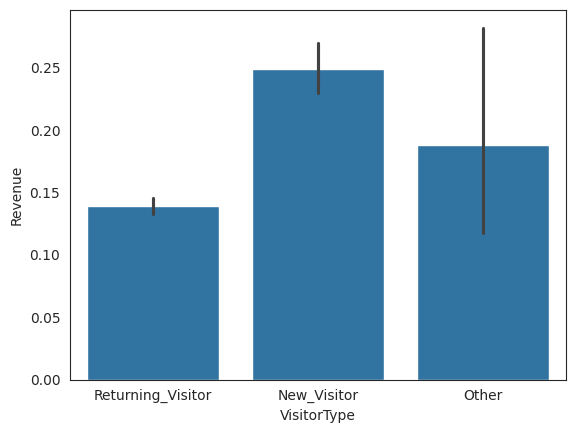

In [86]:
sns.barplot(data = df, x = "VisitorType", y = "Revenue")

Although we have more returning visitor, new visitors tend to create more revenue for us. Hence we can focus on them and other typed visitors.

### Weekend

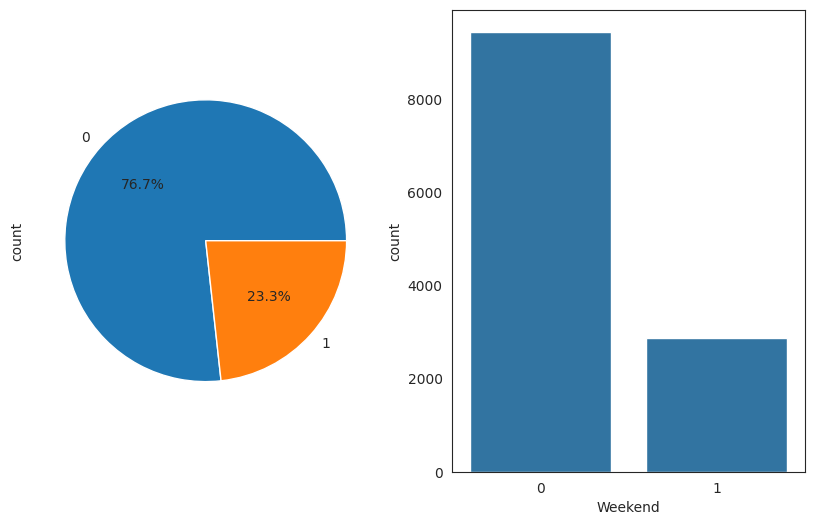

In [87]:
categorical_pie(df, "Weekend")

Weekends has the density similar to a weekends/weekdays.

<Axes: xlabel='Weekend', ylabel='Revenue'>

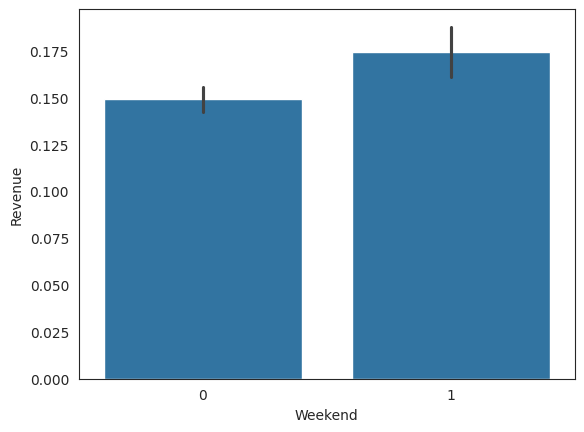

In [88]:
sns.barplot(data = df, x = "Weekend", y = "Revenue")

Naturally, people tends to buy more on the weekends.

### Revenue

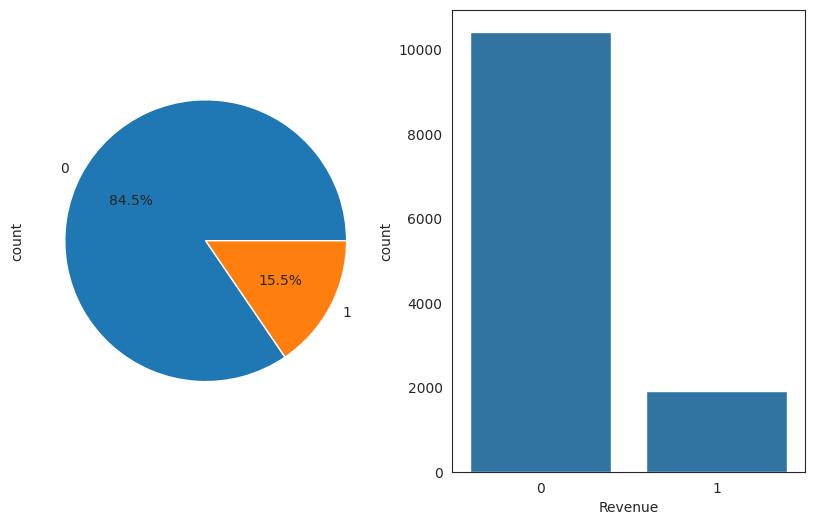

In [89]:
categorical_pie(df, "Revenue")

We have an imbalanced dataset. Hence we should not only care about accuracy but also focus on AUC, F-1 score and particular recall scores.

## Scatter Plots of Numeric Variables

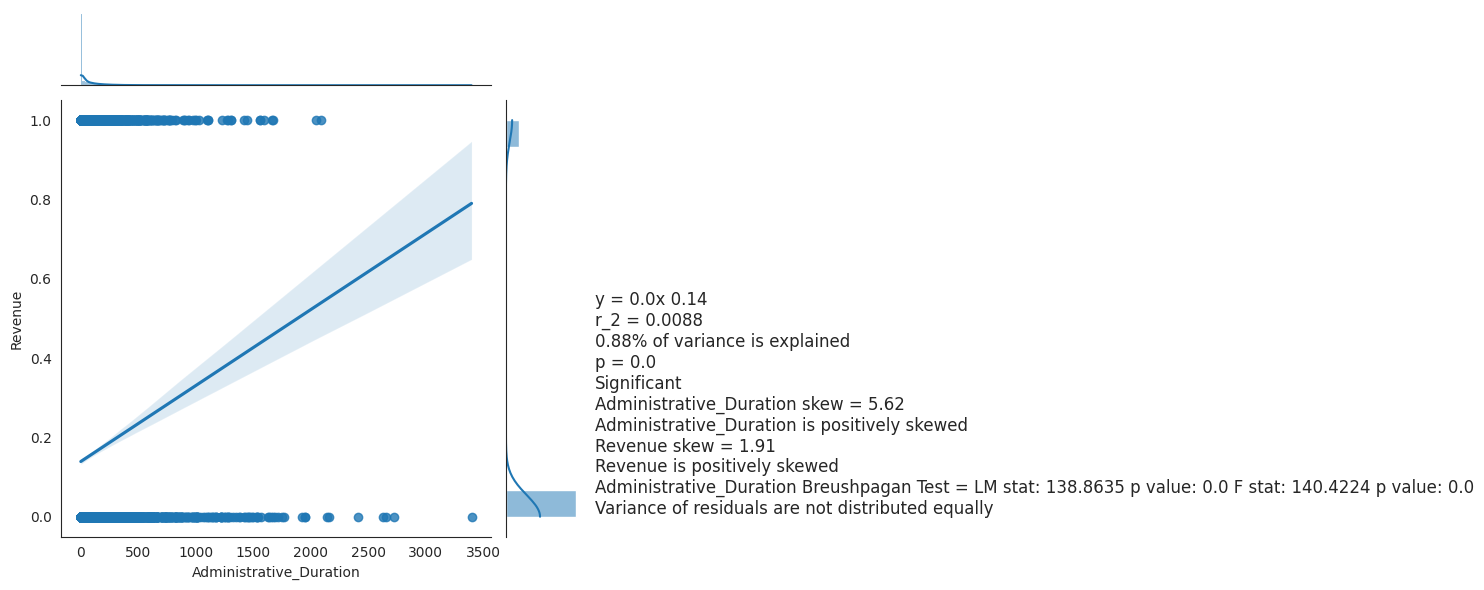

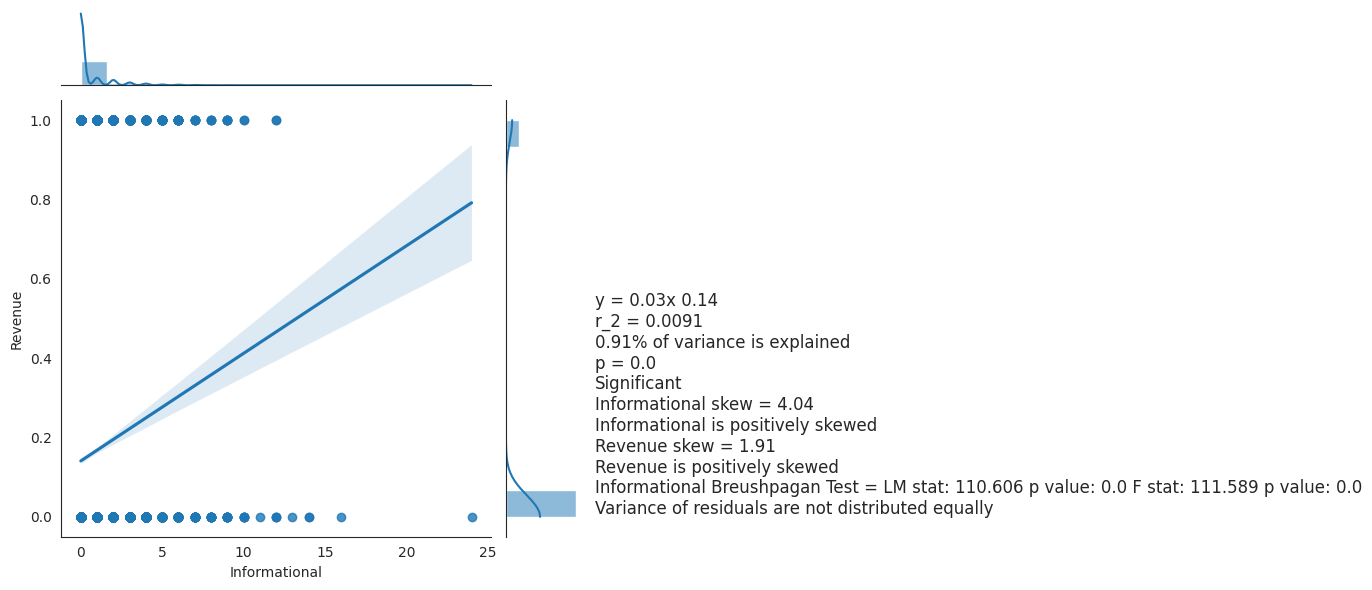

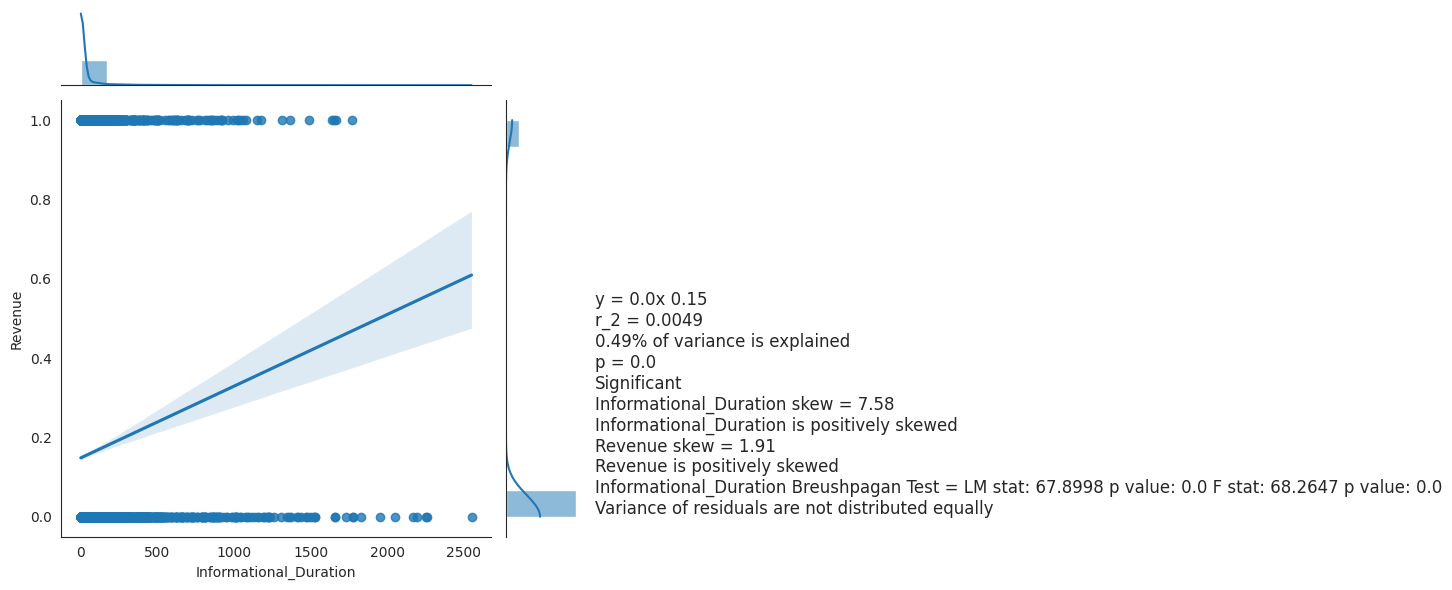

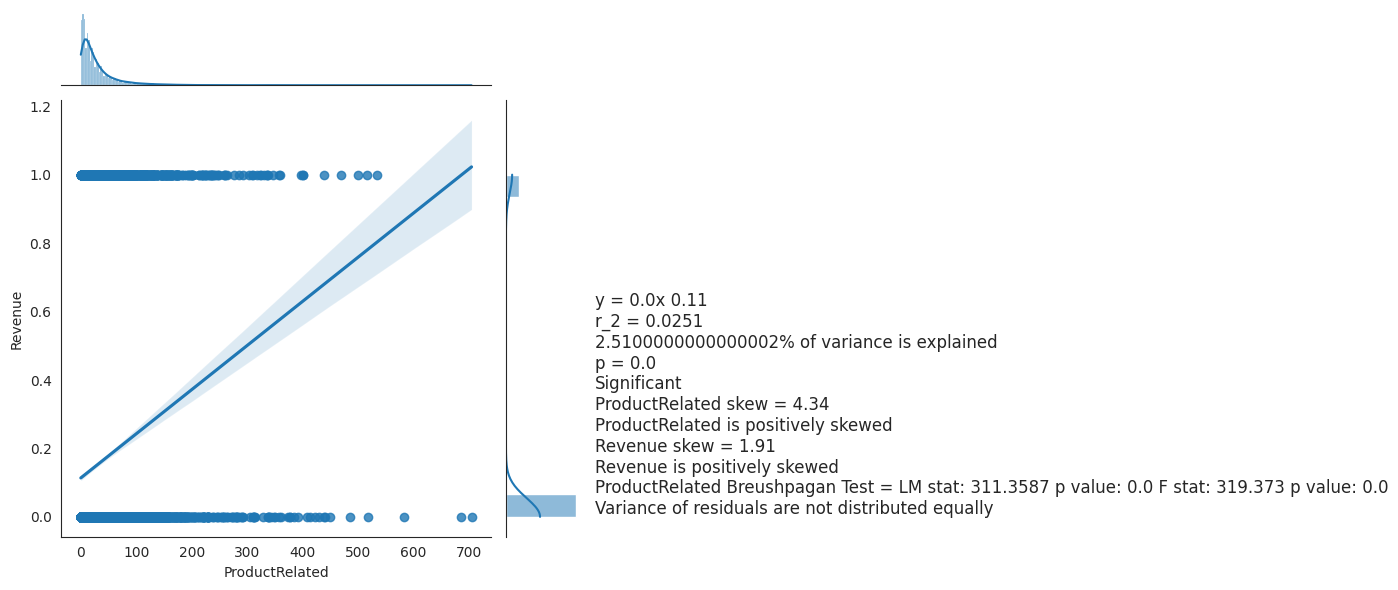

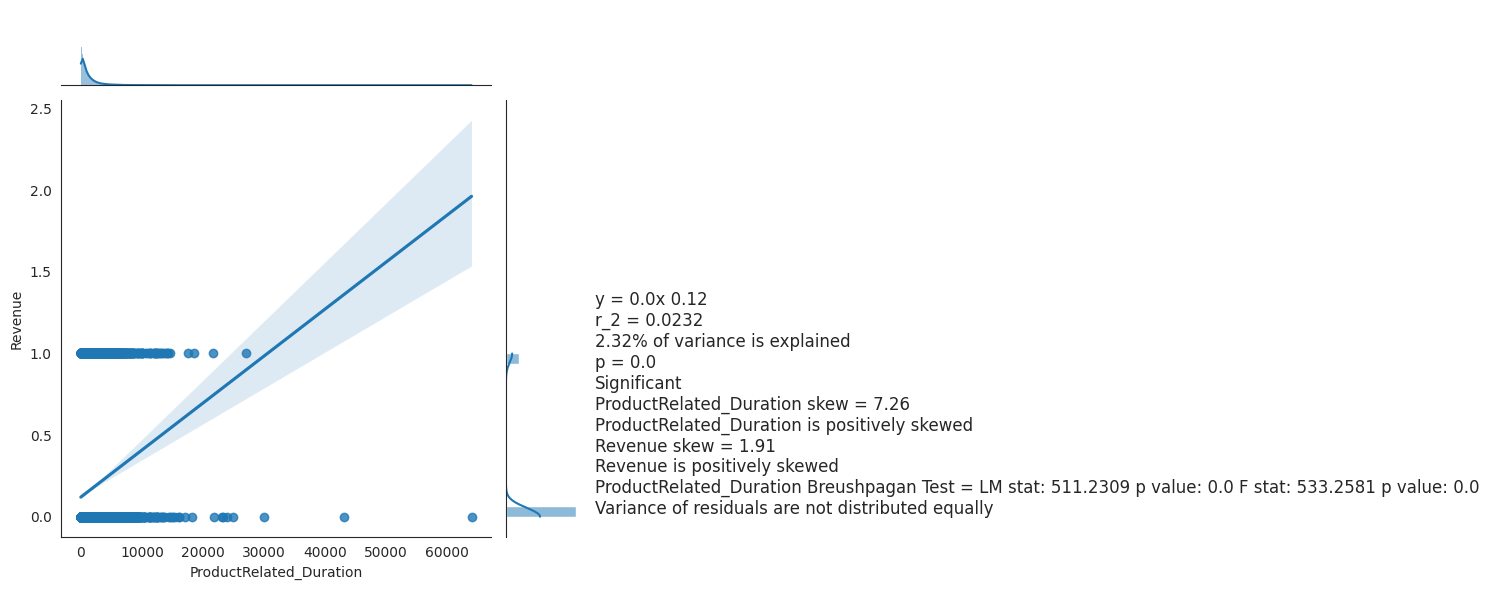

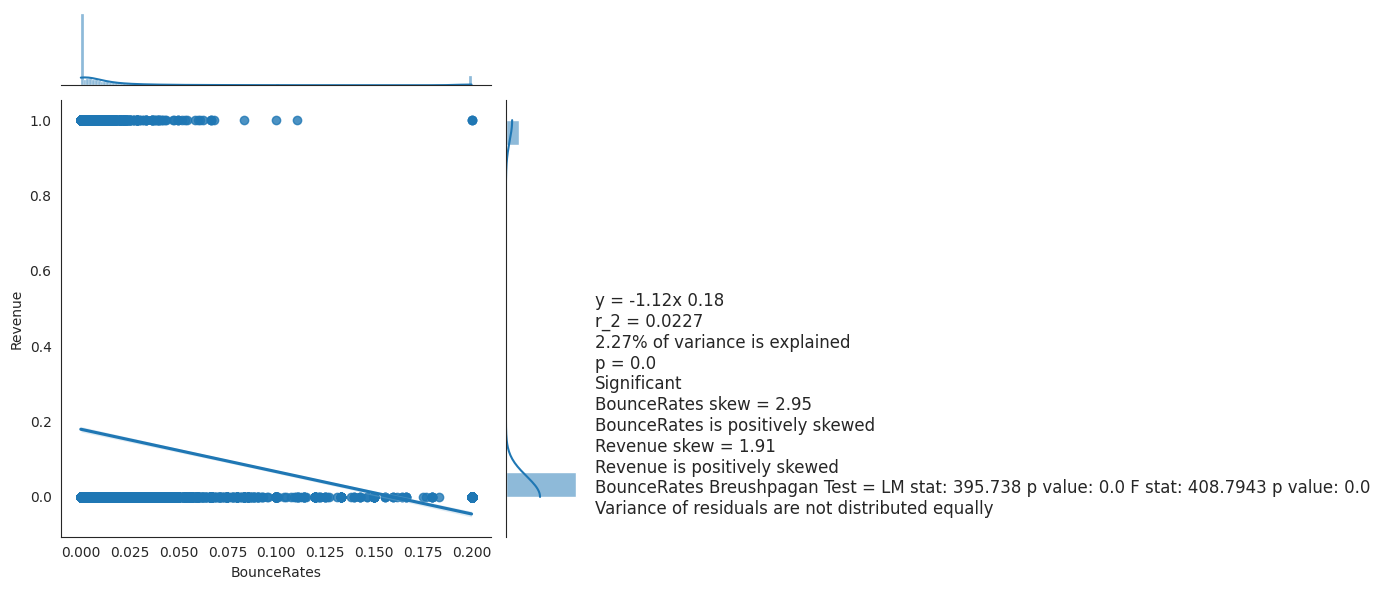

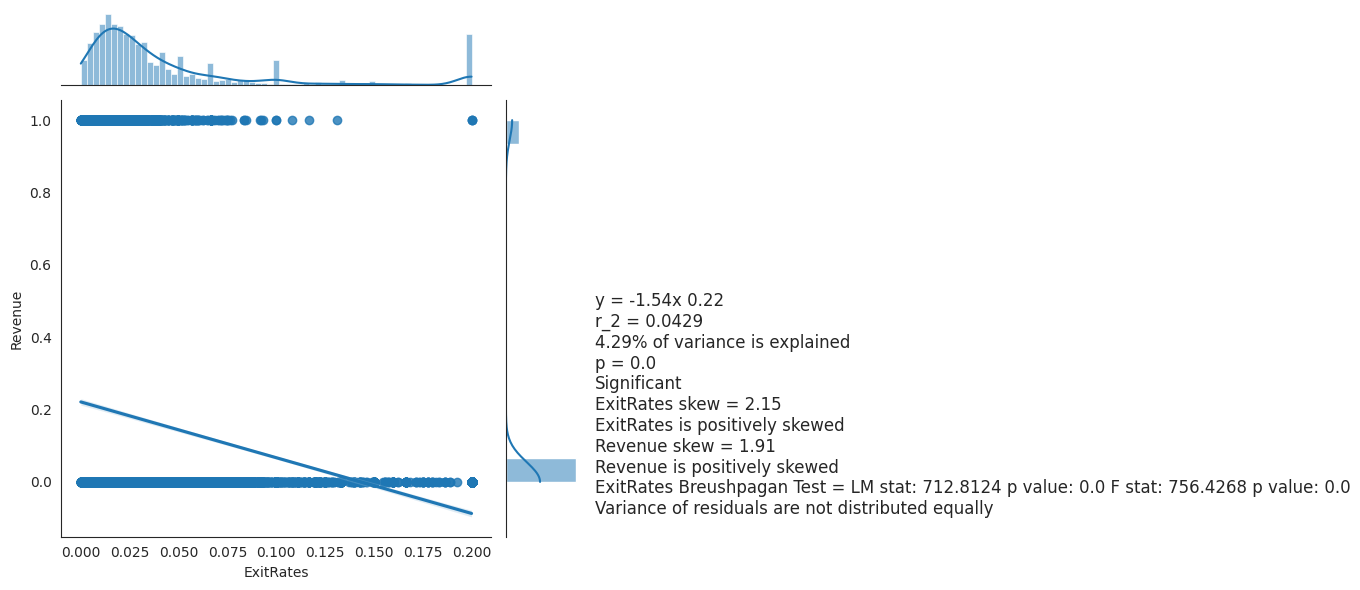

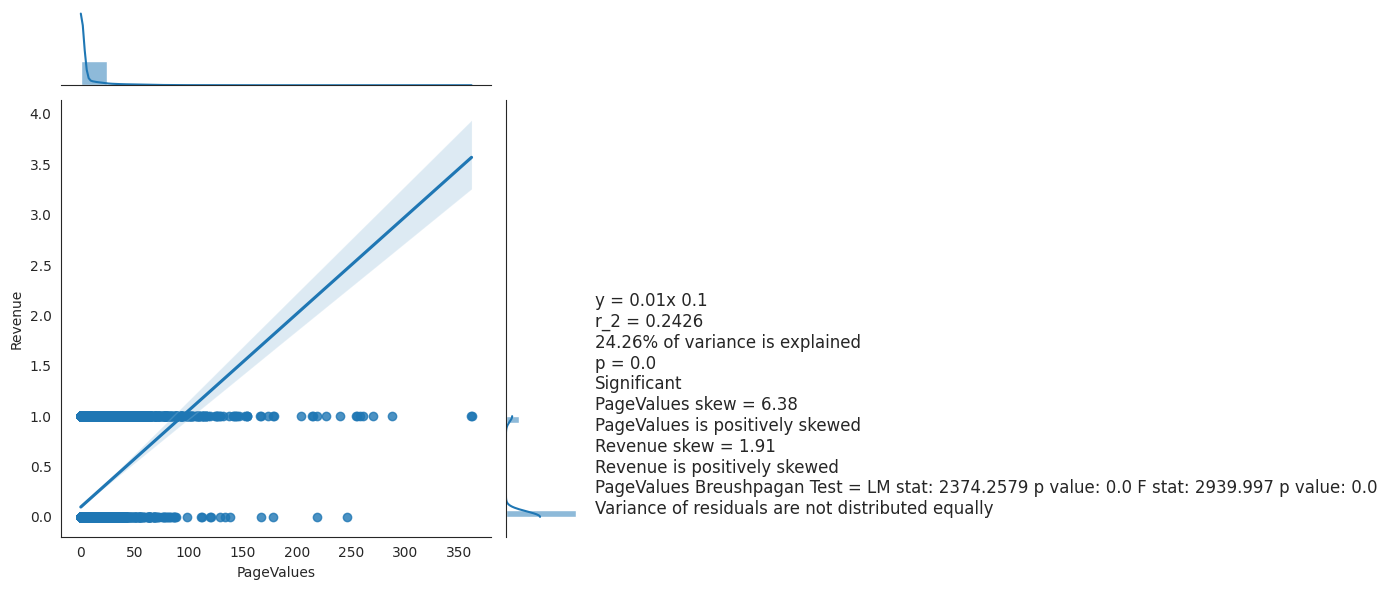

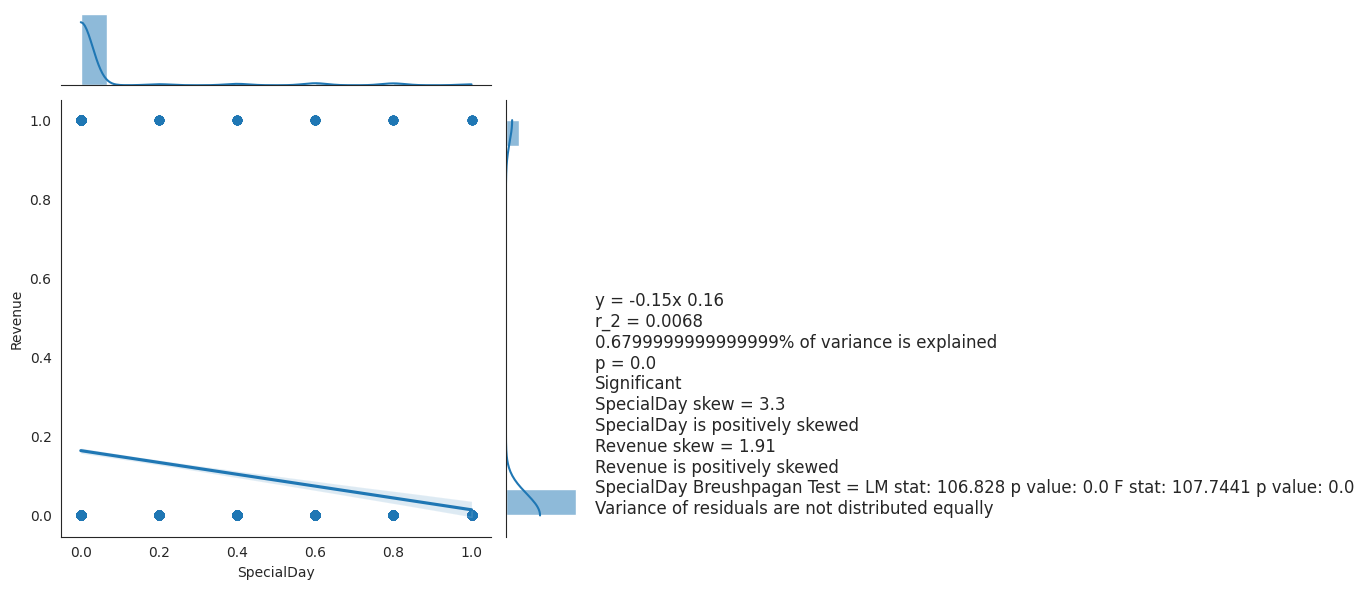

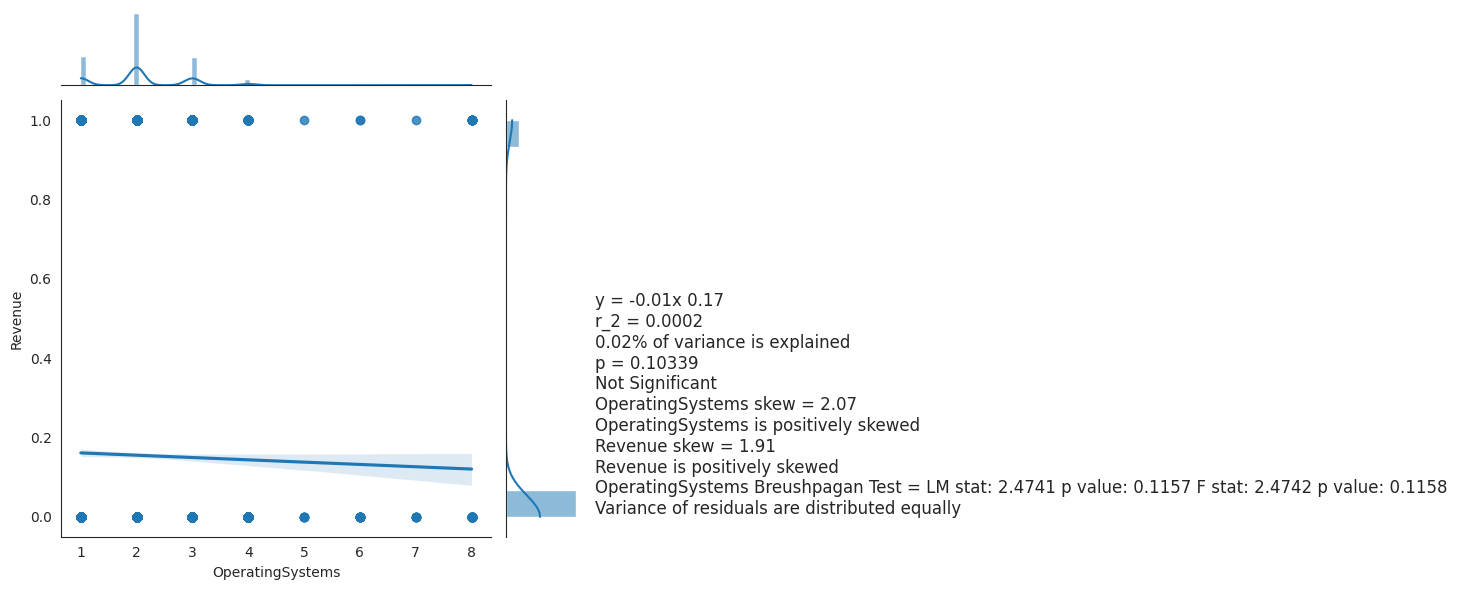

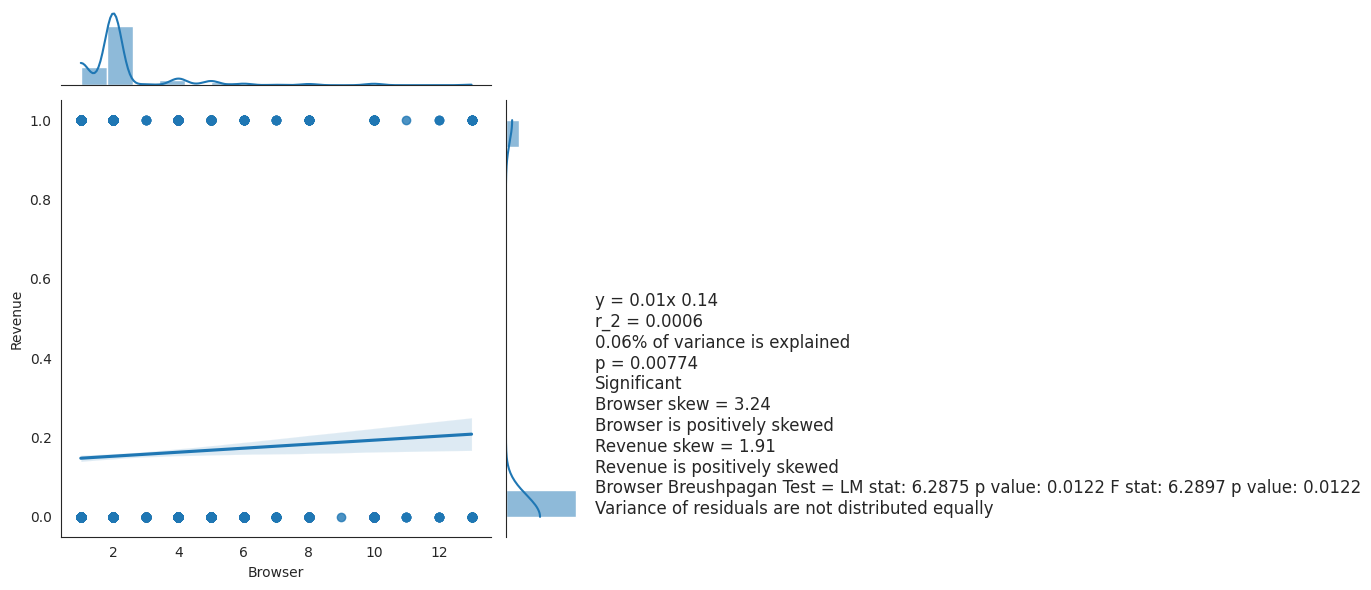

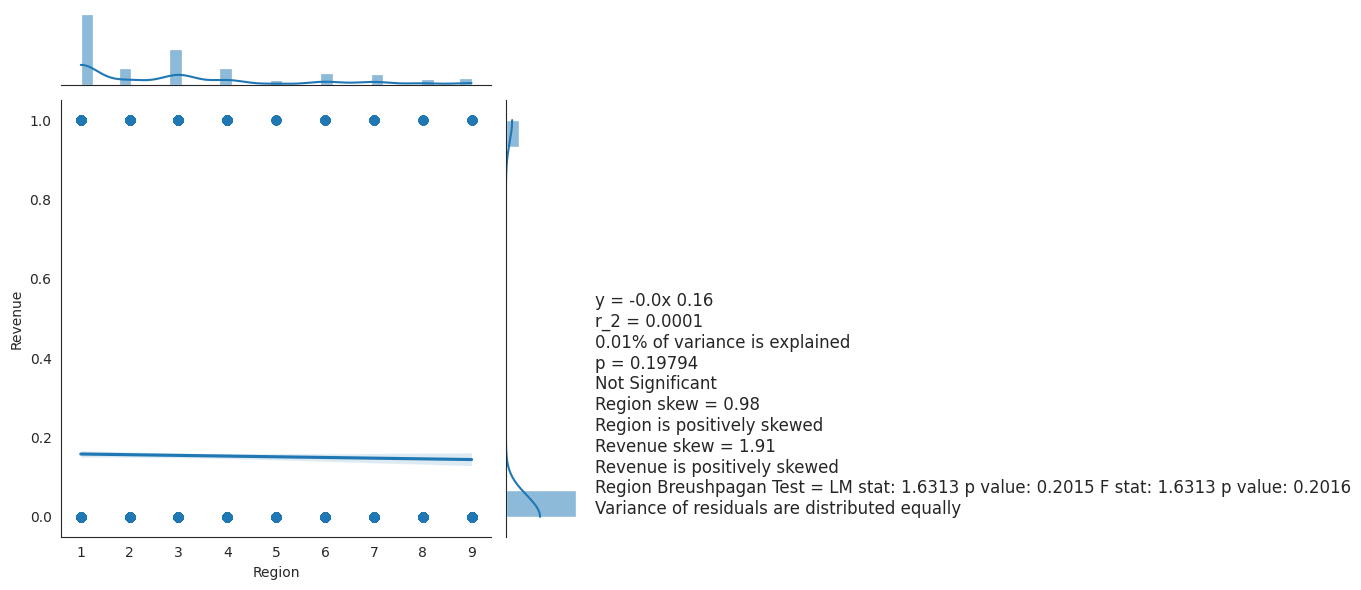

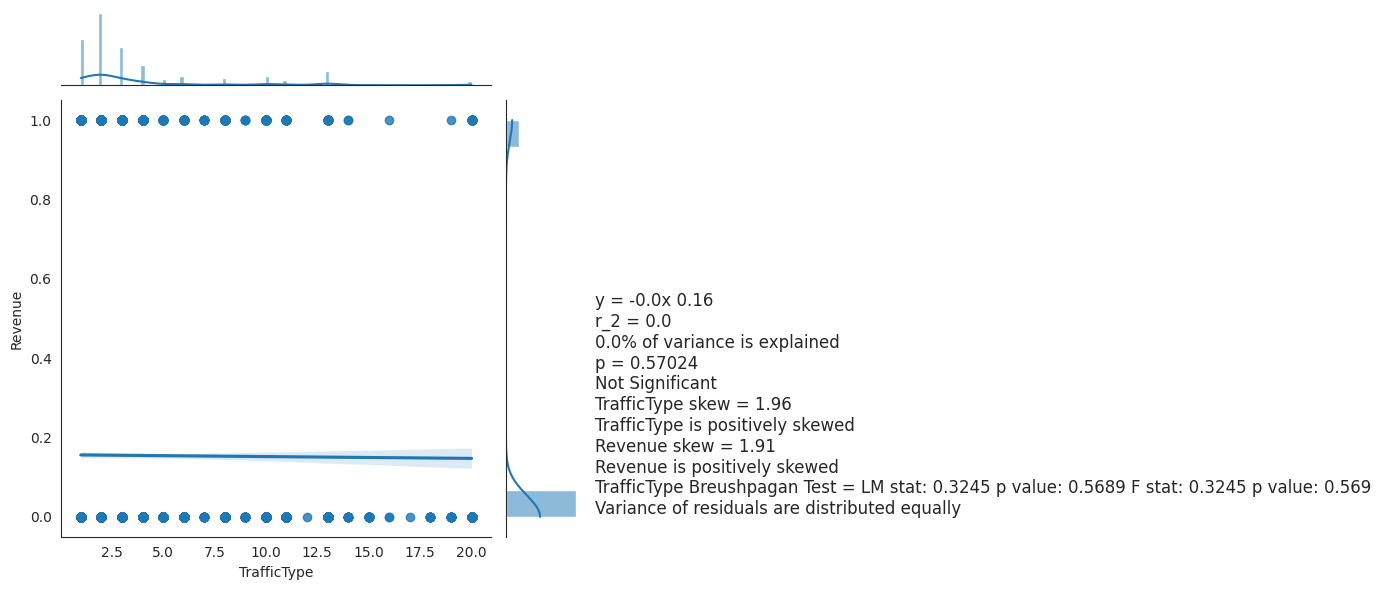

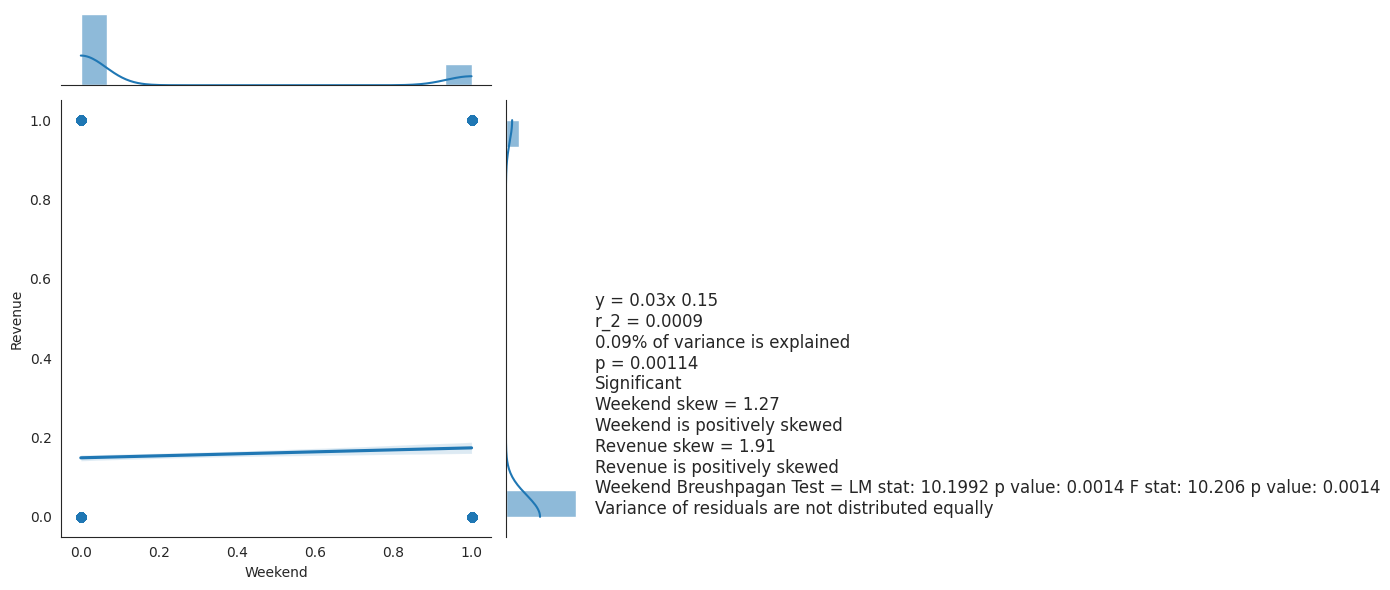

In [95]:
for col in df.drop("Revenue", axis = 1):
    if pd.api.types.is_numeric_dtype(df[col]):
        scatter(df, "Revenue", col)

* As we mentioned before, pagevalues highly correlates with the revenue. But there are heteroskedasticisity problems, i.e, the residuals are not distributed equally.
* Other than that, not much sufficient correalation among features and target variable.

# Preprocessing

## Missing Values

As we checked before, this dataset does not contaion any missing values.

## Encoding

We can one hot encode:

* Special Day
* Month
* Operation systems
* Browser
* Region
* Traffic Type
* Visitor Type

But as I mentioned earlier, one hot encoding all these categorical features will result in curse of dimensionality problem which is not enough data but too many features. Hence I will only one hot encode the ones that EDA showed related to revenue. Which are:
* Visitor type: One hot encode
* Special Day: One hot encode
* Month: Label encode since too many values

In [96]:
#One hot encode visitor type and special day
df = pd.get_dummies(df, columns = ["VisitorType", "SpecialDay"], drop_first = True, dtype = int)
#We also drop the first column to reduce one more feature

In [105]:
#Label encode the month
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Month"] = le.fit_transform(df["Month"])

## Scaling

We had some contionues variables look alike exponential distribution:
* Administrative and duration
* Information and duration
* Product and duration
* Exit rates
* Bounce rates

Lets try a log transformation for these features.

In [99]:
#log transformation
df["Administrative_log"] = np.log(df["Administrative"]+1)
df["Administrative_Duration_log"] = np.log(df["Administrative_Duration"]+1)

df["Informational_log"] = np.log(df["Informational"]+1)
df["Informational_Duration_log"] = np.log(df["Informational_Duration"]+1)

df["ProductRelated_log"] = np.log(df["ProductRelated"]+1)
df["ProductRelated_Duration_log"] = np.log(df["ProductRelated_Duration"]+1)

df["ExitRates_log"] = np.log(df["ExitRates"]+1)
df["BounceRates_log"] = np.log(df["BounceRates"]+1)

In [103]:
#Lets look at the correlation with new features
correlation(df,"Revenue")

,Columns,P-Value,Correlation Coefficient(r),Absolute r
PageValues,Revenue-PageValues,0.0000,0.492569,0.492569
ExitRates_log,Revenue-ExitRates_log,0.0000,-0.210738,0.210738
ExitRates,Revenue-ExitRates,0.0000,-0.207071,0.207071
ProductRelated_log,Revenue-ProductRelated_log,0.0000,0.201379,0.201379
ProductRelated_Duration_log,Revenue-ProductRelated_Duration_log,0.0000,0.200062,0.200062
Administrative_Duration_log,Revenue-Administrative_Duration_log,0.0000,0.166544,0.166544
Administrative_log,Revenue-Administrative_log,0.0000,0.163083,0.163083
ProductRelated,Revenue-ProductRelated,0.0000,0.158538,0.158538
BounceRates_log,Revenue-BounceRates_log,0.0000,-0.152814,0.152814
ProductRelated_Duration,Revenue-ProductRelated_Duration,0.0000,0.152373,0.152373


* Log version of features are slightly better than the old one in terms of correlation with target variable.

# Feature Engineering

In [106]:
# Quick look at the updated dataframe
unistats(df)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Administrative,12330,0,27,int64,0.000000,2.315166,0.0,0.000000,1.000000,4.000000,27.000000,3.321784,1.960357,4.701146
Informational,12330,0,17,int64,0.000000,0.503569,0.0,0.000000,0.000000,0.000000,24.000000,1.270156,4.036464,26.932266
ProductRelated,12330,0,311,int64,1.000000,31.731468,0.0,7.000000,18.000000,38.000000,705.000000,44.475503,4.341516,31.211707
Month,12330,0,10,int64,6.000000,5.163990,0.0,5.000000,6.000000,7.000000,9.000000,2.370199,-0.832535,-0.368330
OperatingSystems,12330,0,8,int64,2.000000,2.124006,1.0,2.000000,2.000000,3.000000,8.000000,0.911325,2.066285,10.456843
Browser,12330,0,13,int64,2.000000,2.357097,1.0,2.000000,2.000000,2.000000,13.000000,1.717277,3.242350,12.746733
Region,12330,0,9,int64,1.000000,3.147364,1.0,1.000000,3.000000,4.000000,9.000000,2.401591,0.983549,-0.148680
TrafficType,12330,0,20,int64,2.000000,4.069586,1.0,2.000000,2.000000,4.000000,20.000000,4.025169,1.962987,3.479711
Weekend,12330,0,2,int64,0.000000,0.232603,0.0,0.000000,0.000000,0.000000,1.000000,0.422509,1.265962,-0.397404
Revenue,12330,0,2,int64,0.000000,0.154745,0.0,0.000000,0.000000,0.000000,1.000000,0.361676,1.909509,1.646493


We have configured all features into numeric ones.

## Feature Selection

### Select K Best Method

In [121]:
from sklearn.feature_selection import SelectKBest, chi2

In [122]:
k_best = SelectKBest(chi2, k = 10)
k_best.fit(df.drop("Revenue", axis = 1), df["Revenue"])

SelectKBest(score_func=<function chi2 at 0x7fa50ba77eb0>)

In [125]:
print(k_best.get_feature_names_out())
k_best_features = k_best.get_feature_names_out()

['Administrative' 'Administrative_Duration' 'Informational'
 'Informational_Duration' 'ProductRelated' 'ProductRelated_Duration'
 'PageValues' 'Administrative_Duration_log' 'Informational_Duration_log'
 'ProductRelated_Duration_log']


# Modelling

I will apply various models to different feature sets above I obtained with different methods. And compare the results.

## Train Test Split

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop("Revenue", axis = 1), df["Revenue"], test_size = 0.2, random_state = 42)

## Logistic Regression

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

In [222]:
log_model_1 = LogisticRegression(random_state = 42)
log_model_1.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Train Accuracy: 0.8814882400648824
Test Accuracy: 0.8669910786699108
Train AUC: 0.6696116027920547
Test AUC: 0.6583941605839416
Train F1: 0.483429076447194
Test F1: 0.4640522875816994
Train Recall: 0.3653974615898464
Test Recall: 0.34549878345498786
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2055
           1       0.71      0.35      0.46       411

    accuracy                           0.87      2466
   macro avg       0.79      0.66      0.69      2466
weighted avg       0.85      0.87      0.85      2466



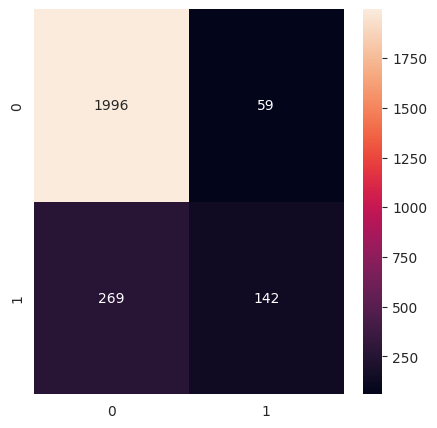

In [223]:
print("Train Accuracy:", log_model_1.score(X_train, y_train))
print("Test Accuracy:", log_model_1.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, log_model_1.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, log_model_1.predict(X_test)))
print("Train F1:", f1_score(y_train, log_model_1.predict(X_train)))
print("Test F1:", f1_score(y_test, log_model_1.predict(X_test)))
print("Train Recall:", recall_score(y_train, log_model_1.predict(X_train)))
print("Test Recall:", recall_score(y_test, log_model_1.predict(X_test)))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, log_model_1.predict(X_test)),annot=True,fmt=".0f")
print(classification_report(y_test, log_model_1.predict(X_test)))
log_1_auc_score = roc_auc_score(y_test, log_model_1.predict(X_test))
log_1_accuracy_score = accuracy_score(y_test, log_model_1.predict(X_test))

As I mentioned above, the imbalanced dataset is although giving good results on overall accuracy failing on the recall of predicting 1s in the test set.

Test AUC: 0.7496350364963503
Test F1: 0.5714285714285713
Test Recall: 0.5985401459854015
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2055
           1       0.55      0.60      0.57       411

    accuracy                           0.85      2466
   macro avg       0.73      0.75      0.74      2466
weighted avg       0.86      0.85      0.85      2466



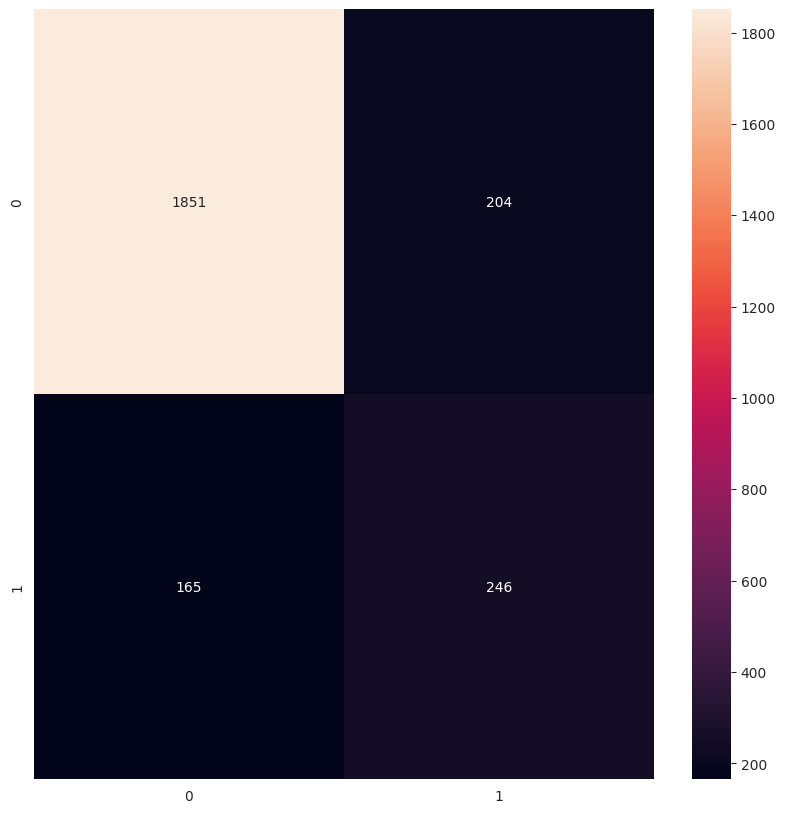

In [224]:
#Lets play with the threshold as 0.4 and see if we can enhance
y_pred = log_model_1.predict_proba(X_test)[:,1] >= 0.2
print("Test AUC:", roc_auc_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt=".0f")
print(classification_report(y_test, y_pred))

Although we managed to increase the recall in class 1, we now lost the recall at class 0. Lets also look at the ROC curve.

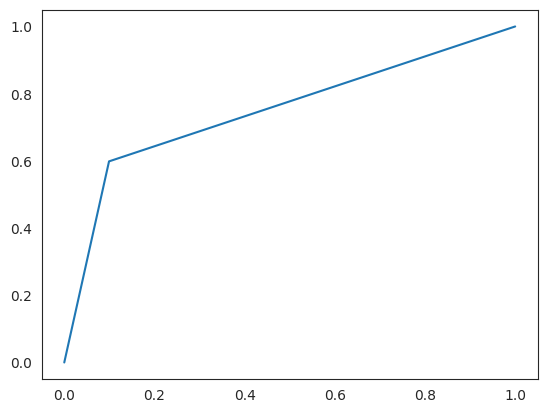

In [225]:
#ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

We want to get close to 0,1 point in the ROC curve. But I will now only look at the initial results of different feature datasets and then play with the thresholds in Model Optimization part.

In [226]:
log_model_2 = LogisticRegression(random_state = 42)
log_model_2.fit(X_train[k_best_features], y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Train Accuracy: 0.8813868613138686
Test Accuracy: 0.8661800486618005
Train AUC: 0.6695518442166992
Test AUC: 0.6598540145985402
Train F1: 0.48321554770318026
Test F1: 0.46601941747572817
Train Recall: 0.3653974615898464
Test Recall: 0.35036496350364965
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2055
           1       0.70      0.35      0.47       411

    accuracy                           0.87      2466
   macro avg       0.79      0.66      0.69      2466
weighted avg       0.85      0.87      0.85      2466



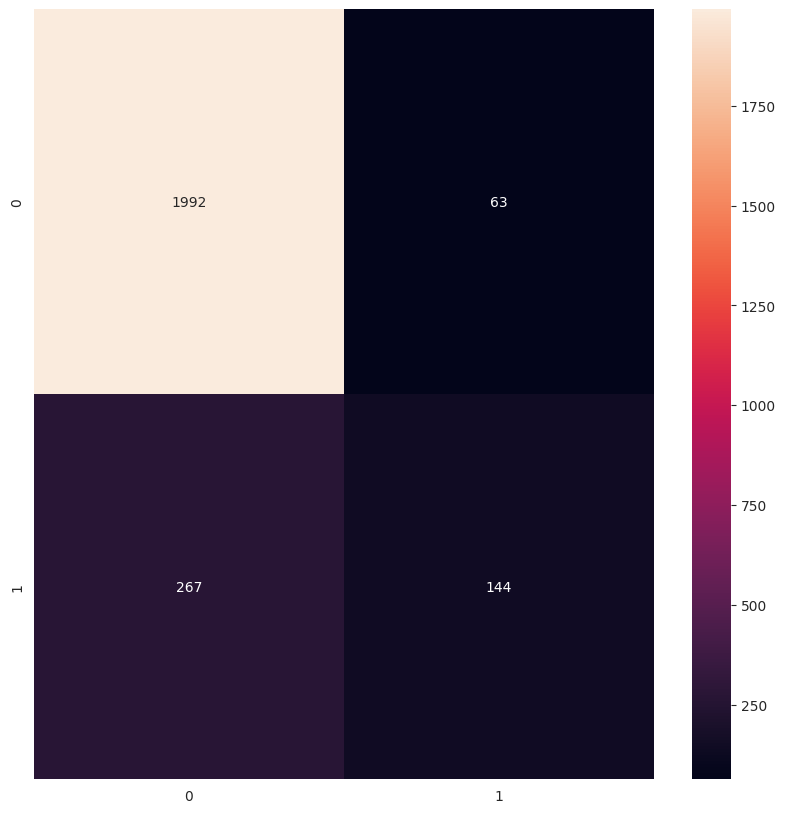

In [227]:
print("Train Accuracy:", log_model_2.score(X_train[k_best_features], y_train))
print("Test Accuracy:", log_model_2.score(X_test[k_best_features], y_test))
print("Train AUC:", roc_auc_score(y_train, log_model_2.predict(X_train[k_best_features])))
print("Test AUC:", roc_auc_score(y_test, log_model_2.predict(X_test[k_best_features])))
print("Train F1:", f1_score(y_train, log_model_2.predict(X_train[k_best_features])))
print("Test F1:", f1_score(y_test, log_model_2.predict(X_test[k_best_features])))
print("Train Recall:", recall_score(y_train, log_model_2.predict(X_train[k_best_features])))
print("Test Recall:", recall_score(y_test, log_model_2.predict(X_test[k_best_features])))
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test, log_model_2.predict(X_test[k_best_features])),annot=True,fmt=".0f")
print(classification_report(y_test, log_model_2.predict(X_test[k_best_features])))
log_2_auc_score = roc_auc_score(y_test, log_model_2.predict(X_test[k_best_features]))
log_2_accuracy_score = accuracy_score(y_test, log_model_2.predict(X_test[k_best_features]))

Gave out a similar result as using all features. With low recall and high accuracy.

## Random Forest

In [152]:
from sklearn.ensemble import RandomForestClassifier

In [153]:
rdc_model_1 = RandomForestClassifier(random_state = 42)
rdc_model_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Train Accuracy: 1.0
Test Accuracy: 0.8953771289537713
Train AUC: 1.0
Test AUC: 0.7464720194647203
Train F1: 1.0
Test F1: 0.625
Train Recall: 1.0
Test Recall: 0.5231143552311436
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2055
           1       0.78      0.52      0.62       411

    accuracy                           0.90      2466
   macro avg       0.84      0.75      0.78      2466
weighted avg       0.89      0.90      0.89      2466



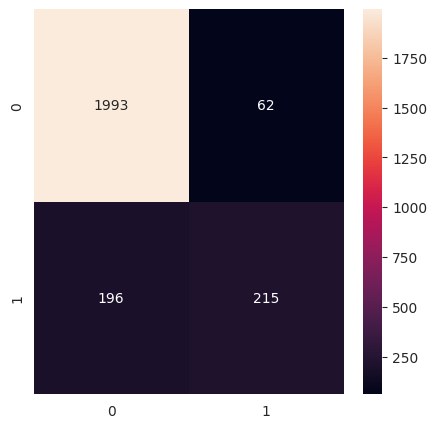

In [155]:
print("Train Accuracy:", rdc_model_1.score(X_train, y_train))
print("Test Accuracy:", rdc_model_1.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, rdc_model_1.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, rdc_model_1.predict(X_test)))
print("Train F1:", f1_score(y_train, rdc_model_1.predict(X_train)))
print("Test F1:", f1_score(y_test, rdc_model_1.predict(X_test)))
print("Train Recall:", recall_score(y_train, rdc_model_1.predict(X_train)))
print("Test Recall:", recall_score(y_test, rdc_model_1.predict(X_test)))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, rdc_model_1.predict(X_test)),annot=True,fmt=".0f")
print(classification_report(y_test, rdc_model_1.predict(X_test)))


We have a much better recall and accuracy level than the logistic regression. We also managed to increase test AUC, but I guess there is an overfitting issue in the train set since the accuracy seems to be 1.

In [179]:
rdc_auc_score_1 = roc_auc_score(y_test, rdc_model_1.predict(X_test))
rdc_accuracy_score_1 = accuracy_score(y_test, rdc_model_1.predict(X_test))

In [156]:
rfc_model_2 = RandomForestClassifier(random_state = 42)
rfc_model_2.fit(X_train[k_best_features], y_train)

RandomForestClassifier(random_state=42)

Train Accuracy: 0.9995944849959448
Test Accuracy: 0.8775344687753447
Train AUC: 0.9986639946559785
Test AUC: 0.7347931873479319
Train F1: 0.9986622073578596
Test F1: 0.5863013698630136
Train Recall: 0.9973279893119572
Test Recall: 0.5206812652068127
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2055
           1       0.67      0.52      0.59       411

    accuracy                           0.88      2466
   macro avg       0.79      0.73      0.76      2466
weighted avg       0.87      0.88      0.87      2466



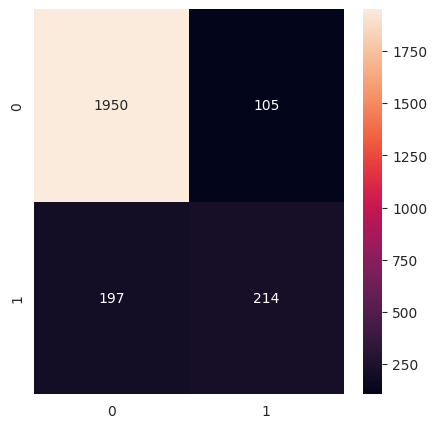

In [161]:
print("Train Accuracy:", rfc_model_2.score(X_train[k_best_features], y_train))
print("Test Accuracy:", rfc_model_2.score(X_test[k_best_features], y_test))
print("Train AUC:", roc_auc_score(y_train, rfc_model_2.predict(X_train[k_best_features])))
print("Test AUC:", roc_auc_score(y_test, rfc_model_2.predict(X_test[k_best_features])))
print("Train F1:", f1_score(y_train, rfc_model_2.predict(X_train[k_best_features])))
print("Test F1:", f1_score(y_test, rfc_model_2.predict(X_test[k_best_features])))
print("Train Recall:", recall_score(y_train, rfc_model_2.predict(X_train[k_best_features])))
print("Test Recall:", recall_score(y_test, rfc_model_2.predict(X_test[k_best_features])))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test ,rfc_model_2.predict(X_test[k_best_features])),annot=True,fmt=".0f")
print(classification_report(y_test, rfc_model_2.predict(X_test[k_best_features])))

There is certainly a problem with the overfitting.

In [180]:
rfc_model_2_auc_score = roc_auc_score(y_test, rfc_model_2.predict(X_test[k_best_features]))
rfc_model_2_accuracy_score = accuracy_score(y_test, rfc_model_2.predict(X_test[k_best_features]))

In [163]:
#Reduce overfitting
rfc_model_3 = RandomForestClassifier(random_state = 42, max_depth=4)
rfc_model_3.fit(X_train[k_best_features], y_train)

Train Accuracy: 0.8987226277372263
Test Accuracy: 0.8844282238442822


In [164]:
print("Train Accuracy:", rfc_model_3.score(X_train[k_best_features], y_train))
print("Test Accuracy:", rfc_model_3.score(X_test[k_best_features], y_test))
print("Train AUC:", roc_auc_score(y_train, rfc_model_3.predict(X_train[k_best_features])))
print("Test AUC:", roc_auc_score(y_test, rfc_model_3.predict(X_test[k_best_features])))

Train Accuracy: 0.8987226277372263
Test Accuracy: 0.8844282238442822
Train AUC: 0.7231009167851659
Test AUC: 0.7038929440389294


In [181]:
rfc_model_3_auc_score = roc_auc_score(y_test, rfc_model_3.predict(X_test[k_best_features]))
rfc_model_3_accuracy_score = accuracy_score(y_test, rfc_model_3.predict(X_test[k_best_features]))

Now we have a more general model since train accuracy and AUC values are near.

## XGBoost

In [165]:
from xgboost import XGBClassifier

In [168]:
xgb_model_1 = XGBClassifier(random_state = 42, max_depth = 4)
xgb_model_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Train Accuracy: 0.9486009732360098
Test Accuracy: 0.8917274939172749
Train AUC: 0.8693295518969096
Test AUC: 0.7666666666666667
Train F1: 0.8169014084507044
Test F1: 0.6406460296096904
Train Recall: 0.7555110220440882
Test Recall: 0.5790754257907542
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2055
           1       0.72      0.58      0.64       411

    accuracy                           0.89      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.89      0.89      0.89      2466



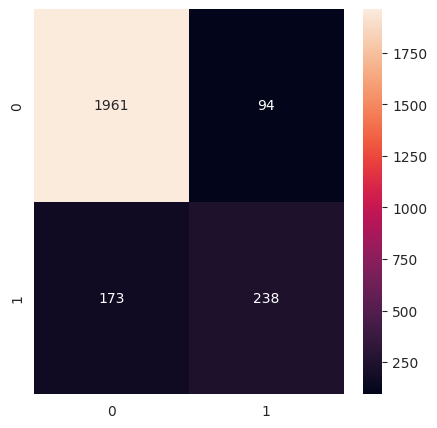

In [169]:
print("Train Accuracy:", xgb_model_1.score(X_train, y_train))
print("Test Accuracy:", xgb_model_1.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, xgb_model_1.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, xgb_model_1.predict(X_test)))
print("Train F1:", f1_score(y_train, xgb_model_1.predict(X_train)))
print("Test F1:", f1_score(y_test, xgb_model_1.predict(X_test)))
print("Train Recall:", recall_score(y_train, xgb_model_1.predict(X_train)))
print("Test Recall:", recall_score(y_test, xgb_model_1.predict(X_test)))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, xgb_model_1.predict(X_test)),annot=True,fmt=".0f")
print(classification_report(y_test, xgb_model_1.predict(X_test)))


When I run without specifying the max depth, the model overfits easily. Hence I used 4 initiavely and got rid of overfitting. Later we will already optimize these parameters. In summary, XGboost performend better in terms of test AUC and recall values.

In [182]:
xgb_model_1_auc_score = roc_auc_score(y_test, xgb_model_1.predict(X_test))
xgb_model_1_accuracy_score = accuracy_score(y_test, xgb_model_1.predict(X_test))

In [170]:
xgb_model_2 = XGBClassifier(random_state = 42, max_depth = 4)
xgb_model_2.fit(X_train[k_best_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Train Accuracy: 0.9377534468775345
Test Accuracy: 0.875506893755069
Train AUC: 0.8453838476522784
Test AUC: 0.7306569343065694
Train F1: 0.7765647743813683
Test F1: 0.578875171467764
Train Recall: 0.7127588510354042
Test Recall: 0.51338199513382
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2055
           1       0.66      0.51      0.58       411

    accuracy                           0.88      2466
   macro avg       0.79      0.73      0.75      2466
weighted avg       0.87      0.88      0.87      2466



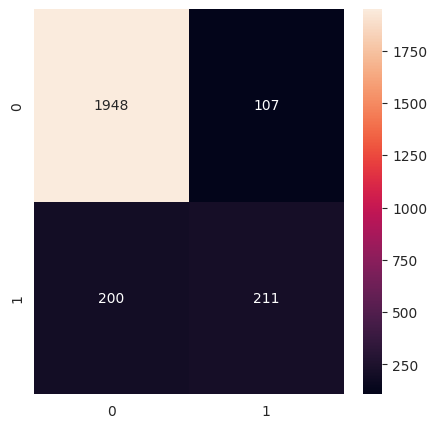

In [171]:
print("Train Accuracy:", xgb_model_2.score(X_train[k_best_features], y_train))
print("Test Accuracy:", xgb_model_2.score(X_test[k_best_features], y_test))
print("Train AUC:", roc_auc_score(y_train, xgb_model_2.predict(X_train[k_best_features])))
print("Test AUC:", roc_auc_score(y_test, xgb_model_2.predict(X_test[k_best_features])))
print("Train F1:", f1_score(y_train, xgb_model_2.predict(X_train[k_best_features])))
print("Test F1:", f1_score(y_test, xgb_model_2.predict(X_test[k_best_features])))
print("Train Recall:", recall_score(y_train, xgb_model_2.predict(X_train[k_best_features])))
print("Test Recall:", recall_score(y_test, xgb_model_2.predict(X_test[k_best_features])))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, xgb_model_2.predict(X_test[k_best_features])),annot=True,fmt=".0f")
print(classification_report(y_test, xgb_model_2.predict(X_test[k_best_features])))



Second feature set performend worse than initial set.

In [183]:
xgb_model_2_auc_score = roc_auc_score(y_test, xgb_model_2.predict(X_test[k_best_features]))
xgb_model_2_accuracy_score = accuracy_score(y_test, xgb_model_2.predict(X_test[k_best_features]))

## SVM

In [172]:
from sklearn.svm import SVC

In [173]:
svc_model_1 = SVC(random_state = 42)
svc_model_1.fit(X_train, y_train)

SVC(random_state=42)

Train Accuracy: 0.8508718572587186
Test Accuracy: 0.8349553933495539
Train AUC: 0.5092325202574385
Test AUC: 0.5058394160583942
Train F1: 0.0366732154551408
Test F1: 0.023980815347721823
Train Recall: 0.018704074816299265
Test Recall: 0.012165450121654502
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2055
           1       0.83      0.01      0.02       411

    accuracy                           0.83      2466
   macro avg       0.83      0.51      0.47      2466
weighted avg       0.83      0.83      0.76      2466



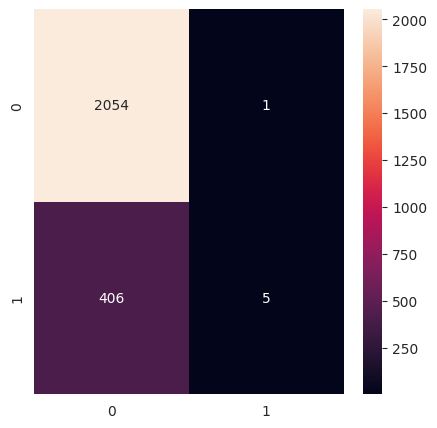

In [174]:
print("Train Accuracy:", svc_model_1.score(X_train, y_train))
print("Test Accuracy:", svc_model_1.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, svc_model_1.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, svc_model_1.predict(X_test)))
print("Train F1:", f1_score(y_train, svc_model_1.predict(X_train)))
print("Test F1:", f1_score(y_test, svc_model_1.predict(X_test)))
print("Train Recall:", recall_score(y_train, svc_model_1.predict(X_train)))
print("Test Recall:", recall_score(y_test, svc_model_1.predict(X_test)))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, svc_model_1.predict(X_test)),annot=True,fmt=".0f")
print(classification_report(y_test, svc_model_1.predict(X_test)))

SVM performed very badly. This may be caused by the linear seperability of the target variable and high number of features. Hence, parameter optimization could work here such as differing the kernel but I will not go into that and directly move into the best models optimization.

In [184]:
svm_model_1_auc_score = roc_auc_score(y_test, svc_model_1.predict(X_test))
svm_model_1_accuracy_score = accuracy_score(y_test, svc_model_1.predict(X_test))

## KNN

In [219]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Train Accuracy: 0.8983171127331712
Test Accuracy: 0.8495539334955393
Train AUC: 0.7118921720577525
Test AUC: 0.6167883211678832
Train F1: 0.5700814402057437
Test F1: 0.37225042301184436
Train Recall: 0.44422177688710757
Test Recall: 0.26763990267639903
              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2055
           1       0.61      0.27      0.37       411

    accuracy                           0.85      2466
   macro avg       0.74      0.62      0.64      2466
weighted avg       0.83      0.85      0.82      2466



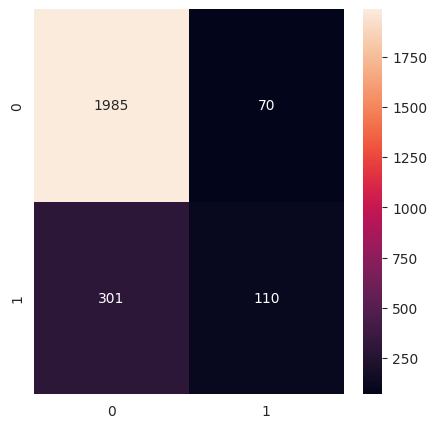

In [220]:
print("Train Accuracy:", knn_model.score(X_train, y_train))
print("Test Accuracy:", knn_model.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, knn_model.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, knn_model.predict(X_test)))
print("Train F1:", f1_score(y_train, knn_model.predict(X_train)))
print("Test F1:", f1_score(y_test, knn_model.predict(X_test)))
print("Train Recall:", recall_score(y_train, knn_model.predict(X_train)))
print("Test Recall:", recall_score(y_test, knn_model.predict(X_test)))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, knn_model.predict(X_test)),annot=True,fmt=".0f")
print(classification_report(y_test, knn_model.predict(X_test)))

KNN model did not perform well either since the data points are not enough and there is no distinct seperability among customers.

## Decision Tree

In [203]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [210]:
dtc = DecisionTreeClassifier(random_state = 42, max_depth=3
                             )
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [211]:
print("Train Accuracy:", dtc.score(X_train, y_train))
print("Test Accuracy:", dtc.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, dtc.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, dtc.predict(X_test)))

Train Accuracy: 0.8982157339821574
Test Accuracy: 0.8868613138686131
Train AUC: 0.7949279699592805
Test AUC: 0.7773722627737227


[Text(0.5, 0.875, 'PageValues <= 0.992\ngini = 0.257\nsamples = 9864\nvalue = [8367, 1497]\nclass = 0'),
 Text(0.25, 0.625, 'Month <= 6.5\ngini = 0.075\nsamples = 7755\nvalue = [7453, 302]\nclass = 0'),
 Text(0.125, 0.375, 'Month <= 4.5\ngini = 0.025\nsamples = 5381\nvalue = [5313, 68]\nclass = 0'),
 Text(0.0625, 0.125, 'gini = 0.066\nsamples = 1981\nvalue = [1913, 68]\nclass = 0'),
 Text(0.1875, 0.125, 'gini = 0.0\nsamples = 3400\nvalue = [3400, 0]\nclass = 0'),
 Text(0.375, 0.375, 'ProductRelated <= 55.5\ngini = 0.178\nsamples = 2374\nvalue = [2140, 234]\nclass = 0'),
 Text(0.3125, 0.125, 'gini = 0.138\nsamples = 1939\nvalue = [1794, 145]\nclass = 0'),
 Text(0.4375, 0.125, 'gini = 0.325\nsamples = 435\nvalue = [346, 89]\nclass = 0'),
 Text(0.75, 0.625, 'BounceRates <= 0.0\ngini = 0.491\nsamples = 2109\nvalue = [914, 1195]\nclass = 1'),
 Text(0.625, 0.375, 'PageValues <= 19.785\ngini = 0.389\nsamples = 957\nvalue = [253, 704]\nclass = 1'),
 Text(0.5625, 0.125, 'gini = 0.492\nsamples =

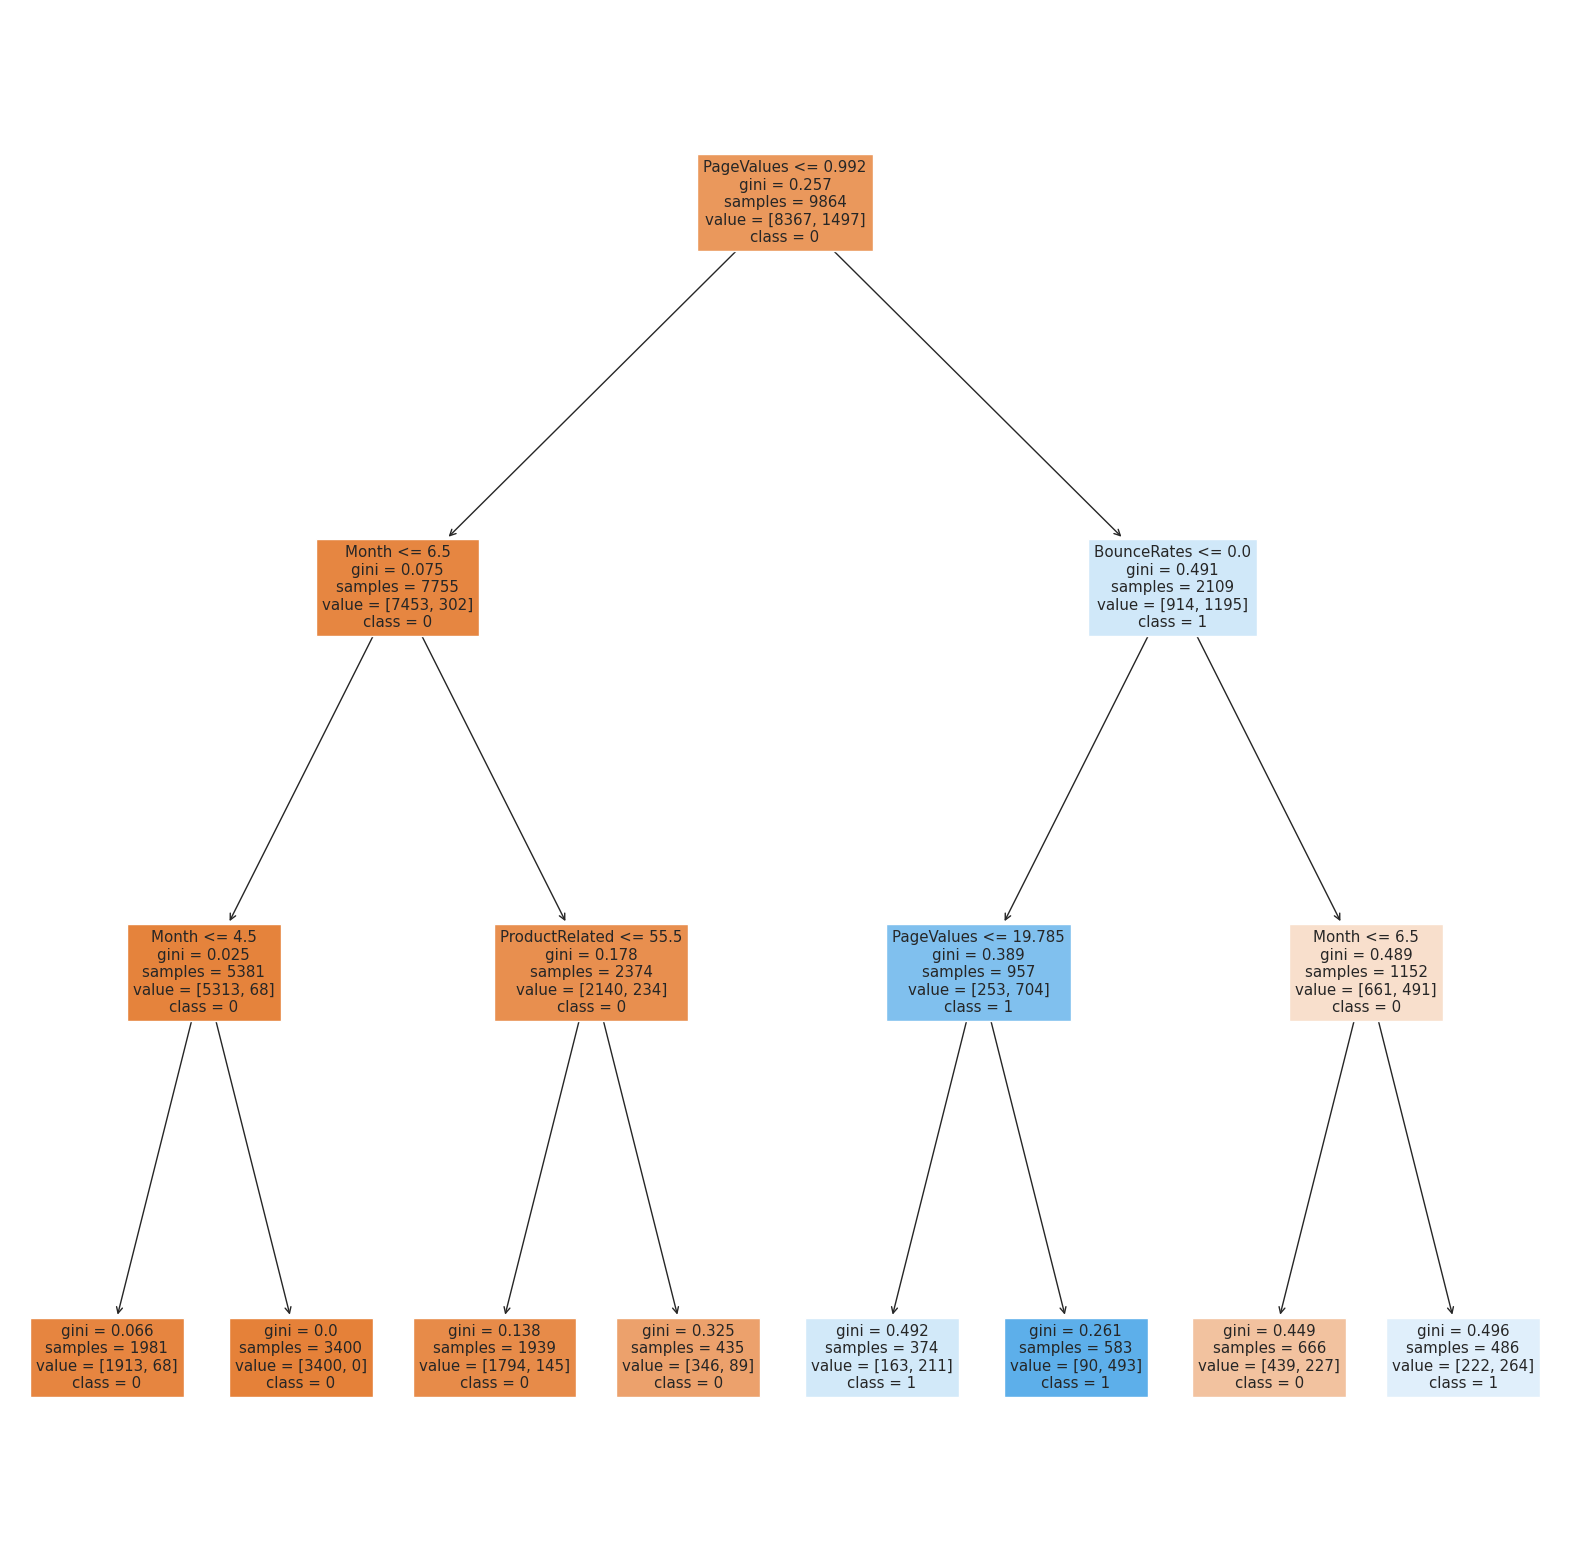

In [213]:
plt.figure(figsize = (20,20))
plot_tree(dtc, filled = True, feature_names = X_train.columns, class_names=["0", "1"])

## Model Comparison

In [193]:
models = ["Logistic Regression", "Random Forest", "XGBoost", "SVM"]
auc_scores_1 = [log_1_auc_score, rdc_auc_score_1, xgb_model_1_auc_score, svm_model_1_auc_score]
auc_scores_2 = [log_2_auc_score, rfc_model_2_auc_score, xgb_model_2_auc_score]
accuracy_scores = [log_1_accuracy_score, rdc_accuracy_score_1, xgb_model_1_accuracy_score, svm_model_1_accuracy_score]
accuracy_scores_2 = [log_2_accuracy_score, rfc_model_2_accuracy_score, xgb_model_2_accuracy_score]
accuracy_df = pd.DataFrame({"Model": models, "Accuracy": accuracy_scores})
auc_df = pd.DataFrame({"Model": models, "AUC": auc_scores})

<Axes: xlabel='Model', ylabel='AUC'>

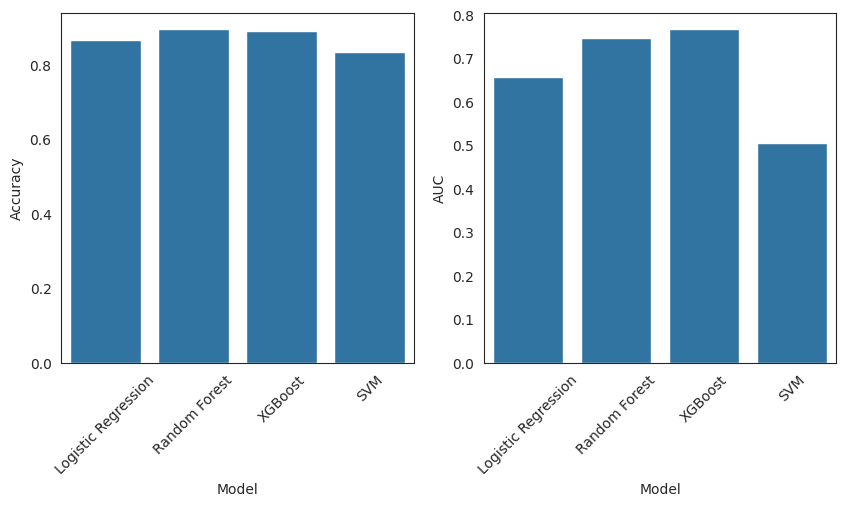

In [197]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.xticks(rotation = 45)
sns.barplot(data = accuracy_df, x = "Model", y = "Accuracy")
plt.subplot(2,2,2)
plt.xticks(rotation = 45)
sns.barplot(data = auc_df, x = "Model", y = "AUC")

As we can see from the comparison above, AUC score has best in XGBoost. Hence I will try to improve XGBoost with parameter tuning.

# Model Optimization

## Parameter Tuning

In [198]:
from sklearn.model_selection import GridSearchCV

In [201]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [214]:
grid_model = GridSearchCV(XGBClassifier(random_state = 42), param_grid, cv = 5, scoring = "roc_auc")
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [215]:
print("Best Parameters:", grid_model.best_params_)
print("Best Score:", grid_model.best_score_)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Score: 0.9340345048294312


Train Accuracy: 0.9277169505271695
Test Accuracy: 0.8957826439578265
Train AUC: 0.8167055995581458
Test AUC: 0.7652068126520681
Train F1: 0.7340544572920553
Test F1: 0.6455172413793102
Train Recall: 0.657314629258517
Test Recall: 0.5693430656934306
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2055
           1       0.75      0.57      0.65       411

    accuracy                           0.90      2466
   macro avg       0.83      0.77      0.79      2466
weighted avg       0.89      0.90      0.89      2466



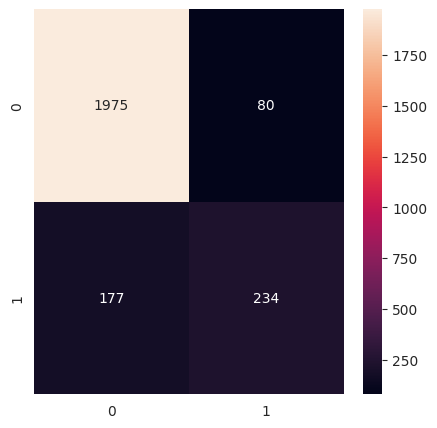

In [216]:
print("Train Accuracy:", grid_model.best_estimator_.score(X_train, y_train))
print("Test Accuracy:", grid_model.best_estimator_.score(X_test, y_test))
print("Train AUC:", roc_auc_score(y_train, grid_model.best_estimator_.predict(X_train)))
print("Test AUC:", roc_auc_score(y_test, grid_model.best_estimator_.predict(X_test)))
print("Train F1:", f1_score(y_train, grid_model.best_estimator_.predict(X_train)))
print("Test F1:", f1_score(y_test, grid_model.best_estimator_.predict(X_test)))
print("Train Recall:", recall_score(y_train, grid_model.best_estimator_.predict(X_train)))
print("Test Recall:", recall_score(y_test, grid_model.best_estimator_.predict(X_test)))
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(y_test, grid_model.best_estimator_.predict(X_test)),annot=True,fmt=".0f")
print(classification_report(y_test, grid_model.best_estimator_.predict(X_test)))

Our best model came out as XGBoost with parameters learning rate 0.05, max depth is 5 and number of estimators is 100.

#### Threshold Selection to Maximize AUC

In [259]:
best_score = 0
for i in range(0,100):
    y_pred = grid_model.best_estimator_.predict_proba(X_train)[:,1] >= i/100
    score = roc_auc_score(y_train, y_pred)
    if score > best_score:
        best_score = score
        best_threshold = i/100
print("Best Score:", best_score)
print("Best Threshold:", i/100)

Best Score: 0.8847180437126194
Best Threshold: 0.99


Here best threshold value came out as 0.99. This means that, the model is not labelling class 0 unless it is fully sure of it. This is caused by the imbalanced dataset.

Pros:
* We will have better chance of predicting customers
* Better at cathcing customers

Cons:
* The projection could be much more than the reality
* Excess use of resources
* Unrealistic profit predictions to shareholders

Test AUC: 0.8571776155717761


<Axes: >

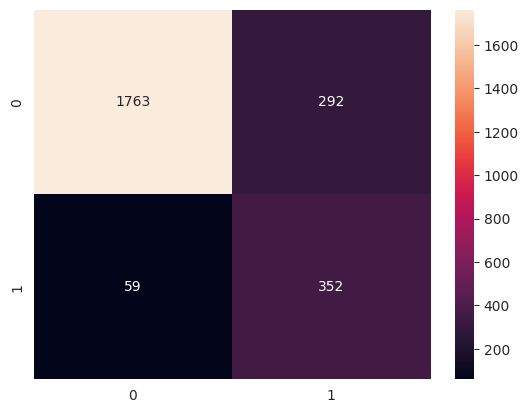

In [263]:
y_pred = grid_model.best_estimator_.predict_proba(X_test)[:,1] >= best_threshold
print("Test AUC:", roc_auc_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt=".0f")

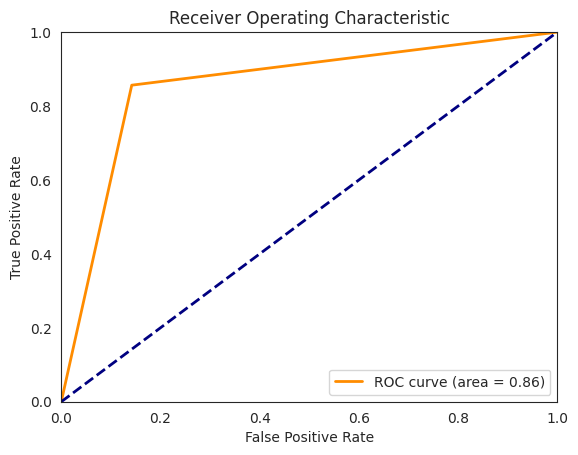

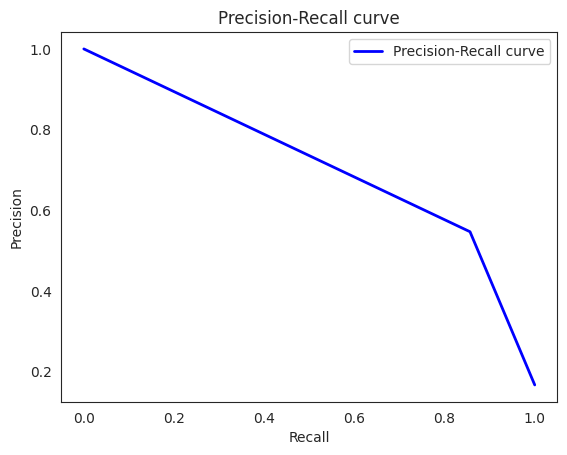

In [261]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, lw=2, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

ROC curve is maxium with value 0.86 with above parameters.

## Cross Validation

In [264]:
from sklearn.model_selection import cross_val_score
print("Cross Validation Scores:", cross_val_score(grid_model.best_estimator_, X_train, y_train, cv = 5, scoring = "roc_auc"))

Cross Validation Scores: [0.93443198 0.9291815  0.94635784 0.92297171 0.9372295 ]


In [218]:
print("Variance of cv scores:", np.var(cross_val_score(grid_model.best_estimator_, X_train, y_train, cv = 5, scoring = "roc_auc")))

Variance of cv scores: 6.163353792274125e-05


* Here we can see that the cv scores are similar with a very low variance among them hence the model can be generalizable.



# Insights

## Optimization of the Website from The Decision Tree and EDA

* Node 1: As we have seen in the EDA, as customer takes time between different pages. He/she tends to buy more. Hence, we should firstly focus on the experience of the customers among pages
* Month is an important attribute we should look at, after june we tend to sell more. Hence we can design our campaigns after june.
* Special day revenues are not as expected, hence we can arrange our campaigns in a better way to attract people in those days
* We can add some adds to our product related page to continue surfing
* User friendly interface is the most important reccomandation to make of course
* Increase the number of features such as age groups, gender, hour of day